In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 828)
(4629816, 8)
validation
(621056, 828)
(621056, 8)
test
(624904, 828)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

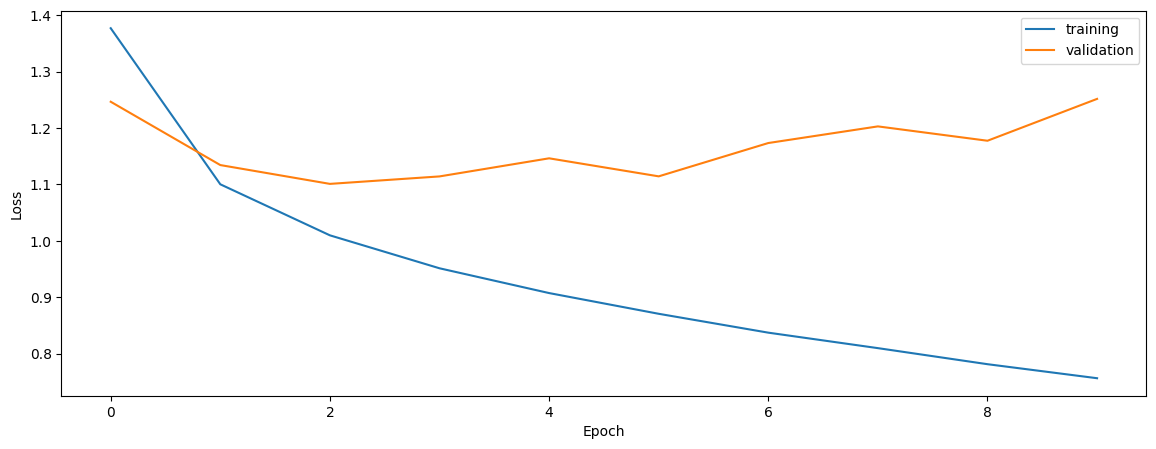

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True
props['collapse_bin'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'BCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_BCE_7_1_0_1_1_1_t1t2_normalized_e_n_e_0_0_e_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1254584, 828)
(1254584, 1)
validation
(166224, 828)
(166224, 1)
test
(164640, 828)
(164640, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 828)]             0         


 dense_5 (Dense)             (None, 1024)              848896    


 dense_6 (Dense)             (None, 512)               524800    


 dense_7 (Dense)             (None, 256)               131328    


 dense_8 (Dense)             (None, 128)               32896     


 dense_9 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/126 [..............................] - ETA: 2:32 - loss: 1.0849 - STD: 8.7246e-05 - MAE: 0.5711

  4/126 [..............................] - ETA: 2s - loss: 0.8026 - STD: 5.2208e-04 - MAE: 0.5044  

  7/126 [>.............................] - ETA: 2s - loss: 0.7788 - STD: 3.9145e-04 - MAE: 0.4745

 10/126 [=>............................] - ETA: 2s - loss: 0.7544 - STD: 3.2841e-04 - MAE: 0.4661

 14/126 [==>...........................] - ETA: 1s - loss: 0.7306 - STD: 3.1981e-04 - MAE: 0.4701

 18/126 [===>..........................] - ETA: 1s - loss: 0.7204 - STD: 3.2073e-04 - MAE: 0.4757

 22/126 [====>.........................] - ETA: 1s - loss: 0.7113 - STD: 3.2325e-04 - MAE: 0.4768

 26/126 [=====>........................] - ETA: 1s - loss: 0.7046 - STD: 3.2453e-04 - MAE: 0.4749

 30/126 [======>.......................] - ETA: 1s - loss: 0.7003 - STD: 3.2952e-04 - MAE: 0.4733

 34/126 [=======>......................] - ETA: 1s - loss: 0.6962 - STD: 3.4351e-04 - MAE: 0.4729

 38/126 [========>.....................] - ETA: 1s - loss: 0.6929 - STD: 3.6445e-04 - MAE: 0.4734

 42/126 [=========>....................] - ETA: 1s - loss: 0.6902 - STD: 3.9155e-04 - MAE: 0.4737

 46/126 [=========>....................] - ETA: 1s - loss: 0.6882 - STD: 4.2396e-04 - MAE: 0.4735

 50/126 [==========>...................] - ETA: 1s - loss: 0.6863 - STD: 4.6545e-04 - MAE: 0.4731

 54/126 [===========>..................] - ETA: 1s - loss: 0.6848 - STD: 5.2147e-04 - MAE: 0.4730

 58/126 [============>.................] - ETA: 1s - loss: 0.6834 - STD: 5.9752e-04 - MAE: 0.4731

 62/126 [=============>................] - ETA: 1s - loss: 0.6823 - STD: 6.9784e-04 - MAE: 0.4732

 66/126 [==============>...............] - ETA: 0s - loss: 0.6813 - STD: 8.3248e-04 - MAE: 0.4732

 70/126 [===============>..............] - ETA: 0s - loss: 0.6802 - STD: 0.0010 - MAE: 0.4731    

 74/126 [================>.............] - ETA: 0s - loss: 0.6793 - STD: 0.0013 - MAE: 0.4730

 78/126 [=================>............] - ETA: 0s - loss: 0.6784 - STD: 0.0017 - MAE: 0.4729

 82/126 [==================>...........] - ETA: 0s - loss: 0.6774 - STD: 0.0022 - MAE: 0.4728

 86/126 [===================>..........] - ETA: 0s - loss: 0.6763 - STD: 0.0030 - MAE: 0.4725

 90/126 [====================>.........] - ETA: 0s - loss: 0.6752 - STD: 0.0042 - MAE: 0.4722

 94/126 [=====================>........] - ETA: 0s - loss: 0.6737 - STD: 0.0060 - MAE: 0.4716

 98/126 [======================>.......] - ETA: 0s - loss: 0.6720 - STD: 0.0084 - MAE: 0.4708

100/126 [======================>.......] - ETA: 0s - loss: 0.6713 - STD: 0.0100 - MAE: 0.4703

104/126 [=======================>......] - ETA: 0s - loss: 0.6693 - STD: 0.0138 - MAE: 0.4690

108/126 [========================>.....] - ETA: 0s - loss: 0.6673 - STD: 0.0183 - MAE: 0.4676

112/126 [=========================>....] - ETA: 0s - loss: 0.6653 - STD: 0.0230 - MAE: 0.4661

116/126 [==========================>...] - ETA: 0s - loss: 0.6632 - STD: 0.0274 - MAE: 0.4645

120/126 [===========================>..] - ETA: 0s - loss: 0.6610 - STD: 0.0315 - MAE: 0.4630

124/126 [============================>.] - ETA: 0s - loss: 0.6587 - STD: 0.0360 - MAE: 0.4613

126/126 [==============================] - 5s 26ms/step - loss: 0.6576 - STD: 0.0384 - MAE: 0.4603 - val_loss: 0.5712 - val_STD: 0.1241 - val_MAE: 0.3885


Epoch 2/10000


  1/126 [..............................] - ETA: 6s - loss: 0.5849 - STD: 0.1809 - MAE: 0.4001

  4/126 [..............................] - ETA: 2s - loss: 0.5837 - STD: 0.1809 - MAE: 0.4010

  8/126 [>.............................] - ETA: 1s - loss: 0.5820 - STD: 0.1806 - MAE: 0.4006

 12/126 [=>............................] - ETA: 1s - loss: 0.5795 - STD: 0.1833 - MAE: 0.3982

 16/126 [==>...........................] - ETA: 1s - loss: 0.5777 - STD: 0.1867 - MAE: 0.3955

 20/126 [===>..........................] - ETA: 1s - loss: 0.5767 - STD: 0.1902 - MAE: 0.3940

 24/126 [====>.........................] - ETA: 1s - loss: 0.5748 - STD: 0.1919 - MAE: 0.3928

 28/126 [=====>........................] - ETA: 1s - loss: 0.5740 - STD: 0.1935 - MAE: 0.3920

 32/126 [======>.......................] - ETA: 1s - loss: 0.5733 - STD: 0.1953 - MAE: 0.3914

 36/126 [=======>......................] - ETA: 1s - loss: 0.5726 - STD: 0.1965 - MAE: 0.3907

 40/126 [========>.....................] - ETA: 1s - loss: 0.5718 - STD: 0.1977 - MAE: 0.3899

 44/126 [=========>....................] - ETA: 1s - loss: 0.5708 - STD: 0.1987 - MAE: 0.3892

 48/126 [==========>...................] - ETA: 1s - loss: 0.5695 - STD: 0.1997 - MAE: 0.3883

 52/126 [===========>..................] - ETA: 1s - loss: 0.5689 - STD: 0.2009 - MAE: 0.3875

 56/126 [============>.................] - ETA: 1s - loss: 0.5683 - STD: 0.2022 - MAE: 0.3867

 60/126 [=============>................] - ETA: 0s - loss: 0.5677 - STD: 0.2031 - MAE: 0.3862

 64/126 [==============>...............] - ETA: 0s - loss: 0.5668 - STD: 0.2039 - MAE: 0.3855

 68/126 [===============>..............] - ETA: 0s - loss: 0.5662 - STD: 0.2049 - MAE: 0.3848

 72/126 [================>.............] - ETA: 0s - loss: 0.5656 - STD: 0.2056 - MAE: 0.3843

 76/126 [=================>............] - ETA: 0s - loss: 0.5650 - STD: 0.2061 - MAE: 0.3839

 80/126 [==================>...........] - ETA: 0s - loss: 0.5647 - STD: 0.2069 - MAE: 0.3836

 84/126 [===================>..........] - ETA: 0s - loss: 0.5642 - STD: 0.2076 - MAE: 0.3832

 88/126 [===================>..........] - ETA: 0s - loss: 0.5636 - STD: 0.2082 - MAE: 0.3825

 92/126 [====================>.........] - ETA: 0s - loss: 0.5629 - STD: 0.2089 - MAE: 0.3819

 96/126 [=====================>........] - ETA: 0s - loss: 0.5625 - STD: 0.2096 - MAE: 0.3816

100/126 [======================>.......] - ETA: 0s - loss: 0.5621 - STD: 0.2099 - MAE: 0.3812

104/126 [=======================>......] - ETA: 0s - loss: 0.5617 - STD: 0.2103 - MAE: 0.3807

108/126 [========================>.....] - ETA: 0s - loss: 0.5612 - STD: 0.2108 - MAE: 0.3804

112/126 [=========================>....] - ETA: 0s - loss: 0.5606 - STD: 0.2113 - MAE: 0.3800

116/126 [==========================>...] - ETA: 0s - loss: 0.5603 - STD: 0.2119 - MAE: 0.3796

120/126 [===========================>..] - ETA: 0s - loss: 0.5598 - STD: 0.2124 - MAE: 0.3792

124/126 [============================>.] - ETA: 0s - loss: 0.5594 - STD: 0.2130 - MAE: 0.3788

126/126 [==============================] - 2s 17ms/step - loss: 0.5592 - STD: 0.2133 - MAE: 0.3785 - val_loss: 0.5386 - val_STD: 0.1783 - val_MAE: 0.3566


Epoch 3/10000


  1/126 [..............................] - ETA: 5s - loss: 0.5462 - STD: 0.2355 - MAE: 0.3645

  5/126 [>.............................] - ETA: 1s - loss: 0.5448 - STD: 0.2291 - MAE: 0.3660

  9/126 [=>............................] - ETA: 1s - loss: 0.5443 - STD: 0.2271 - MAE: 0.3668

 13/126 [==>...........................] - ETA: 1s - loss: 0.5456 - STD: 0.2284 - MAE: 0.3662

 17/126 [===>..........................] - ETA: 1s - loss: 0.5454 - STD: 0.2281 - MAE: 0.3667

 21/126 [====>.........................] - ETA: 1s - loss: 0.5447 - STD: 0.2282 - MAE: 0.3666

 25/126 [====>.........................] - ETA: 1s - loss: 0.5450 - STD: 0.2281 - MAE: 0.3656

 29/126 [=====>........................] - ETA: 1s - loss: 0.5460 - STD: 0.2279 - MAE: 0.3655

 33/126 [======>.......................] - ETA: 1s - loss: 0.5484 - STD: 0.2274 - MAE: 0.3660

 37/126 [=======>......................] - ETA: 1s - loss: 0.5496 - STD: 0.2263 - MAE: 0.3665

 41/126 [========>.....................] - ETA: 1s - loss: 0.5503 - STD: 0.2249 - MAE: 0.3676

 45/126 [=========>....................] - ETA: 1s - loss: 0.5500 - STD: 0.2242 - MAE: 0.3684

 49/126 [==========>...................] - ETA: 1s - loss: 0.5496 - STD: 0.2242 - MAE: 0.3685

 53/126 [===========>..................] - ETA: 1s - loss: 0.5489 - STD: 0.2244 - MAE: 0.3681

 57/126 [============>.................] - ETA: 1s - loss: 0.5481 - STD: 0.2247 - MAE: 0.3677

 61/126 [=============>................] - ETA: 0s - loss: 0.5478 - STD: 0.2256 - MAE: 0.3673

 65/126 [==============>...............] - ETA: 0s - loss: 0.5477 - STD: 0.2262 - MAE: 0.3671

 69/126 [===============>..............] - ETA: 0s - loss: 0.5474 - STD: 0.2266 - MAE: 0.3668

 73/126 [================>.............] - ETA: 0s - loss: 0.5468 - STD: 0.2269 - MAE: 0.3665

 77/126 [=================>............] - ETA: 0s - loss: 0.5464 - STD: 0.2273 - MAE: 0.3663

 81/126 [==================>...........] - ETA: 0s - loss: 0.5461 - STD: 0.2276 - MAE: 0.3662

 85/126 [===================>..........] - ETA: 0s - loss: 0.5458 - STD: 0.2278 - MAE: 0.3660

 89/126 [====================>.........] - ETA: 0s - loss: 0.5453 - STD: 0.2281 - MAE: 0.3657

 93/126 [=====================>........] - ETA: 0s - loss: 0.5452 - STD: 0.2284 - MAE: 0.3655

 97/126 [======================>.......] - ETA: 0s - loss: 0.5448 - STD: 0.2288 - MAE: 0.3652

101/126 [=======================>......] - ETA: 0s - loss: 0.5447 - STD: 0.2293 - MAE: 0.3650

105/126 [========================>.....] - ETA: 0s - loss: 0.5444 - STD: 0.2295 - MAE: 0.3648

109/126 [========================>.....] - ETA: 0s - loss: 0.5441 - STD: 0.2297 - MAE: 0.3646

113/126 [=========================>....] - ETA: 0s - loss: 0.5437 - STD: 0.2299 - MAE: 0.3644

117/126 [==========================>...] - ETA: 0s - loss: 0.5435 - STD: 0.2301 - MAE: 0.3642

121/126 [===========================>..] - ETA: 0s - loss: 0.5432 - STD: 0.2303 - MAE: 0.3640

125/126 [============================>.] - ETA: 0s - loss: 0.5431 - STD: 0.2306 - MAE: 0.3638

126/126 [==============================] - 2s 17ms/step - loss: 0.5430 - STD: 0.2306 - MAE: 0.3638 - val_loss: 0.5354 - val_STD: 0.1761 - val_MAE: 0.3486


Epoch 4/10000


  1/126 [..............................] - ETA: 6s - loss: 0.5354 - STD: 0.2317 - MAE: 0.3529

  4/126 [..............................] - ETA: 2s - loss: 0.5370 - STD: 0.2373 - MAE: 0.3601

  8/126 [>.............................] - ETA: 1s - loss: 0.5365 - STD: 0.2350 - MAE: 0.3597

 12/126 [=>............................] - ETA: 1s - loss: 0.5361 - STD: 0.2362 - MAE: 0.3589

 16/126 [==>...........................] - ETA: 1s - loss: 0.5349 - STD: 0.2364 - MAE: 0.3588

 20/126 [===>..........................] - ETA: 1s - loss: 0.5352 - STD: 0.2369 - MAE: 0.3589

 24/126 [====>.........................] - ETA: 1s - loss: 0.5348 - STD: 0.2377 - MAE: 0.3582

 28/126 [=====>........................] - ETA: 1s - loss: 0.5350 - STD: 0.2375 - MAE: 0.3582

 32/126 [======>.......................] - ETA: 1s - loss: 0.5349 - STD: 0.2375 - MAE: 0.3581

 36/126 [=======>......................] - ETA: 1s - loss: 0.5353 - STD: 0.2382 - MAE: 0.3580

 40/126 [========>.....................] - ETA: 1s - loss: 0.5360 - STD: 0.2380 - MAE: 0.3584

 44/126 [=========>....................] - ETA: 1s - loss: 0.5361 - STD: 0.2370 - MAE: 0.3586

 48/126 [==========>...................] - ETA: 1s - loss: 0.5362 - STD: 0.2367 - MAE: 0.3586

 52/126 [===========>..................] - ETA: 1s - loss: 0.5358 - STD: 0.2368 - MAE: 0.3584

 56/126 [============>.................] - ETA: 1s - loss: 0.5354 - STD: 0.2367 - MAE: 0.3583

 60/126 [=============>................] - ETA: 1s - loss: 0.5351 - STD: 0.2372 - MAE: 0.3580

 64/126 [==============>...............] - ETA: 0s - loss: 0.5348 - STD: 0.2378 - MAE: 0.3576

 68/126 [===============>..............] - ETA: 0s - loss: 0.5348 - STD: 0.2380 - MAE: 0.3574

 72/126 [================>.............] - ETA: 0s - loss: 0.5346 - STD: 0.2379 - MAE: 0.3574

 76/126 [=================>............] - ETA: 0s - loss: 0.5345 - STD: 0.2378 - MAE: 0.3574

 80/126 [==================>...........] - ETA: 0s - loss: 0.5344 - STD: 0.2379 - MAE: 0.3573

 84/126 [===================>..........] - ETA: 0s - loss: 0.5342 - STD: 0.2381 - MAE: 0.3571

 88/126 [===================>..........] - ETA: 0s - loss: 0.5341 - STD: 0.2383 - MAE: 0.3571

 92/126 [====================>.........] - ETA: 0s - loss: 0.5341 - STD: 0.2384 - MAE: 0.3571

 96/126 [=====================>........] - ETA: 0s - loss: 0.5339 - STD: 0.2385 - MAE: 0.3570

100/126 [======================>.......] - ETA: 0s - loss: 0.5337 - STD: 0.2386 - MAE: 0.3569

104/126 [=======================>......] - ETA: 0s - loss: 0.5335 - STD: 0.2389 - MAE: 0.3567

108/126 [========================>.....] - ETA: 0s - loss: 0.5335 - STD: 0.2390 - MAE: 0.3566

112/126 [=========================>....] - ETA: 0s - loss: 0.5334 - STD: 0.2390 - MAE: 0.3565

116/126 [==========================>...] - ETA: 0s - loss: 0.5334 - STD: 0.2390 - MAE: 0.3565

120/126 [===========================>..] - ETA: 0s - loss: 0.5336 - STD: 0.2390 - MAE: 0.3566

124/126 [============================>.] - ETA: 0s - loss: 0.5335 - STD: 0.2389 - MAE: 0.3566

126/126 [==============================] - 2s 18ms/step - loss: 0.5335 - STD: 0.2389 - MAE: 0.3566 - val_loss: 0.5188 - val_STD: 0.1930 - val_MAE: 0.3473


Epoch 5/10000


  1/126 [..............................] - ETA: 5s - loss: 0.5309 - STD: 0.2465 - MAE: 0.3561

  5/126 [>.............................] - ETA: 1s - loss: 0.5298 - STD: 0.2433 - MAE: 0.3543

  9/126 [=>............................] - ETA: 1s - loss: 0.5284 - STD: 0.2426 - MAE: 0.3540

 13/126 [==>...........................] - ETA: 1s - loss: 0.5273 - STD: 0.2433 - MAE: 0.3531

 17/126 [===>..........................] - ETA: 1s - loss: 0.5282 - STD: 0.2446 - MAE: 0.3529

 21/126 [====>.........................] - ETA: 1s - loss: 0.5291 - STD: 0.2434 - MAE: 0.3532

 25/126 [====>.........................] - ETA: 1s - loss: 0.5297 - STD: 0.2428 - MAE: 0.3531

 29/126 [=====>........................] - ETA: 1s - loss: 0.5304 - STD: 0.2430 - MAE: 0.3533

 33/126 [======>.......................] - ETA: 1s - loss: 0.5306 - STD: 0.2421 - MAE: 0.3540

 37/126 [=======>......................] - ETA: 1s - loss: 0.5300 - STD: 0.2418 - MAE: 0.3540

 41/126 [========>.....................] - ETA: 1s - loss: 0.5296 - STD: 0.2423 - MAE: 0.3533

 45/126 [=========>....................] - ETA: 1s - loss: 0.5298 - STD: 0.2422 - MAE: 0.3534

 49/126 [==========>...................] - ETA: 1s - loss: 0.5296 - STD: 0.2419 - MAE: 0.3535

 53/126 [===========>..................] - ETA: 1s - loss: 0.5295 - STD: 0.2422 - MAE: 0.3535

 57/126 [============>.................] - ETA: 1s - loss: 0.5292 - STD: 0.2422 - MAE: 0.3533

 61/126 [=============>................] - ETA: 0s - loss: 0.5289 - STD: 0.2422 - MAE: 0.3533

 65/126 [==============>...............] - ETA: 0s - loss: 0.5286 - STD: 0.2426 - MAE: 0.3530

 69/126 [===============>..............] - ETA: 0s - loss: 0.5284 - STD: 0.2428 - MAE: 0.3529

 73/126 [================>.............] - ETA: 0s - loss: 0.5280 - STD: 0.2431 - MAE: 0.3526

 77/126 [=================>............] - ETA: 0s - loss: 0.5281 - STD: 0.2435 - MAE: 0.3526

 81/126 [==================>...........] - ETA: 0s - loss: 0.5282 - STD: 0.2432 - MAE: 0.3525

 85/126 [===================>..........] - ETA: 0s - loss: 0.5281 - STD: 0.2433 - MAE: 0.3523

 89/126 [====================>.........] - ETA: 0s - loss: 0.5287 - STD: 0.2433 - MAE: 0.3525

 93/126 [=====================>........] - ETA: 0s - loss: 0.5288 - STD: 0.2430 - MAE: 0.3527

 97/126 [======================>.......] - ETA: 0s - loss: 0.5286 - STD: 0.2429 - MAE: 0.3526

101/126 [=======================>......] - ETA: 0s - loss: 0.5286 - STD: 0.2427 - MAE: 0.3527

105/126 [========================>.....] - ETA: 0s - loss: 0.5285 - STD: 0.2429 - MAE: 0.3526

109/126 [========================>.....] - ETA: 0s - loss: 0.5285 - STD: 0.2430 - MAE: 0.3525

113/126 [=========================>....] - ETA: 0s - loss: 0.5283 - STD: 0.2431 - MAE: 0.3525

117/126 [==========================>...] - ETA: 0s - loss: 0.5282 - STD: 0.2432 - MAE: 0.3525

121/126 [===========================>..] - ETA: 0s - loss: 0.5280 - STD: 0.2432 - MAE: 0.3524

125/126 [============================>.] - ETA: 0s - loss: 0.5279 - STD: 0.2431 - MAE: 0.3523

126/126 [==============================] - 2s 17ms/step - loss: 0.5278 - STD: 0.2432 - MAE: 0.3523 - val_loss: 0.5225 - val_STD: 0.1898 - val_MAE: 0.3355


Epoch 6/10000


  1/126 [..............................] - ETA: 5s - loss: 0.5178 - STD: 0.2455 - MAE: 0.3377

  5/126 [>.............................] - ETA: 1s - loss: 0.5225 - STD: 0.2505 - MAE: 0.3437

  9/126 [=>............................] - ETA: 1s - loss: 0.5238 - STD: 0.2456 - MAE: 0.3490

 13/126 [==>...........................] - ETA: 1s - loss: 0.5246 - STD: 0.2469 - MAE: 0.3477

 17/126 [===>..........................] - ETA: 1s - loss: 0.5248 - STD: 0.2465 - MAE: 0.3483

 21/126 [====>.........................] - ETA: 1s - loss: 0.5255 - STD: 0.2452 - MAE: 0.3495

 25/126 [====>.........................] - ETA: 1s - loss: 0.5257 - STD: 0.2462 - MAE: 0.3492

 29/126 [=====>........................] - ETA: 1s - loss: 0.5259 - STD: 0.2453 - MAE: 0.3496

 33/126 [======>.......................] - ETA: 1s - loss: 0.5264 - STD: 0.2446 - MAE: 0.3499

 37/126 [=======>......................] - ETA: 1s - loss: 0.5270 - STD: 0.2445 - MAE: 0.3502

 41/126 [========>.....................] - ETA: 1s - loss: 0.5269 - STD: 0.2437 - MAE: 0.3503

 45/126 [=========>....................] - ETA: 1s - loss: 0.5274 - STD: 0.2441 - MAE: 0.3506

 49/126 [==========>...................] - ETA: 1s - loss: 0.5270 - STD: 0.2440 - MAE: 0.3505

 53/126 [===========>..................] - ETA: 1s - loss: 0.5265 - STD: 0.2440 - MAE: 0.3505

 57/126 [============>.................] - ETA: 1s - loss: 0.5262 - STD: 0.2445 - MAE: 0.3502

 61/126 [=============>................] - ETA: 0s - loss: 0.5258 - STD: 0.2446 - MAE: 0.3500

 65/126 [==============>...............] - ETA: 0s - loss: 0.5255 - STD: 0.2447 - MAE: 0.3498

 69/126 [===============>..............] - ETA: 0s - loss: 0.5253 - STD: 0.2449 - MAE: 0.3497

 73/126 [================>.............] - ETA: 0s - loss: 0.5254 - STD: 0.2449 - MAE: 0.3499

 77/126 [=================>............] - ETA: 0s - loss: 0.5253 - STD: 0.2450 - MAE: 0.3498

 81/126 [==================>...........] - ETA: 0s - loss: 0.5254 - STD: 0.2448 - MAE: 0.3499

 85/126 [===================>..........] - ETA: 0s - loss: 0.5257 - STD: 0.2447 - MAE: 0.3501

 89/126 [====================>.........] - ETA: 0s - loss: 0.5254 - STD: 0.2449 - MAE: 0.3500

 93/126 [=====================>........] - ETA: 0s - loss: 0.5250 - STD: 0.2451 - MAE: 0.3499

 97/126 [======================>.......] - ETA: 0s - loss: 0.5248 - STD: 0.2453 - MAE: 0.3497

101/126 [=======================>......] - ETA: 0s - loss: 0.5247 - STD: 0.2455 - MAE: 0.3495

105/126 [========================>.....] - ETA: 0s - loss: 0.5245 - STD: 0.2455 - MAE: 0.3495

109/126 [========================>.....] - ETA: 0s - loss: 0.5245 - STD: 0.2457 - MAE: 0.3495

113/126 [=========================>....] - ETA: 0s - loss: 0.5244 - STD: 0.2457 - MAE: 0.3494

117/126 [==========================>...] - ETA: 0s - loss: 0.5243 - STD: 0.2458 - MAE: 0.3494

121/126 [===========================>..] - ETA: 0s - loss: 0.5241 - STD: 0.2460 - MAE: 0.3493

125/126 [============================>.] - ETA: 0s - loss: 0.5239 - STD: 0.2461 - MAE: 0.3492

126/126 [==============================] - 2s 17ms/step - loss: 0.5239 - STD: 0.2462 - MAE: 0.3492 - val_loss: 0.5240 - val_STD: 0.1910 - val_MAE: 0.3315


Epoch 7/10000


  1/126 [..............................] - ETA: 5s - loss: 0.5287 - STD: 0.2426 - MAE: 0.3370

  5/126 [>.............................] - ETA: 1s - loss: 0.5277 - STD: 0.2487 - MAE: 0.3458

  9/126 [=>............................] - ETA: 1s - loss: 0.5319 - STD: 0.2462 - MAE: 0.3496

 13/126 [==>...........................] - ETA: 1s - loss: 0.5342 - STD: 0.2430 - MAE: 0.3501

 17/126 [===>..........................] - ETA: 1s - loss: 0.5336 - STD: 0.2412 - MAE: 0.3509

 21/126 [====>.........................] - ETA: 1s - loss: 0.5333 - STD: 0.2406 - MAE: 0.3515

 25/126 [====>.........................] - ETA: 1s - loss: 0.5316 - STD: 0.2412 - MAE: 0.3511

 29/126 [=====>........................] - ETA: 1s - loss: 0.5299 - STD: 0.2414 - MAE: 0.3508

 33/126 [======>.......................] - ETA: 1s - loss: 0.5290 - STD: 0.2417 - MAE: 0.3508

 37/126 [=======>......................] - ETA: 1s - loss: 0.5279 - STD: 0.2420 - MAE: 0.3507

 41/126 [========>.....................] - ETA: 1s - loss: 0.5274 - STD: 0.2424 - MAE: 0.3508

 45/126 [=========>....................] - ETA: 1s - loss: 0.5272 - STD: 0.2429 - MAE: 0.3507

 49/126 [==========>...................] - ETA: 1s - loss: 0.5269 - STD: 0.2432 - MAE: 0.3506

 53/126 [===========>..................] - ETA: 1s - loss: 0.5262 - STD: 0.2438 - MAE: 0.3502

 57/126 [============>.................] - ETA: 1s - loss: 0.5255 - STD: 0.2443 - MAE: 0.3499

 61/126 [=============>................] - ETA: 0s - loss: 0.5252 - STD: 0.2448 - MAE: 0.3496

 65/126 [==============>...............] - ETA: 0s - loss: 0.5246 - STD: 0.2453 - MAE: 0.3492

 69/126 [===============>..............] - ETA: 0s - loss: 0.5241 - STD: 0.2456 - MAE: 0.3489

 73/126 [================>.............] - ETA: 0s - loss: 0.5236 - STD: 0.2460 - MAE: 0.3487

 77/126 [=================>............] - ETA: 0s - loss: 0.5231 - STD: 0.2464 - MAE: 0.3481

 81/126 [==================>...........] - ETA: 0s - loss: 0.5228 - STD: 0.2471 - MAE: 0.3477

 85/126 [===================>..........] - ETA: 0s - loss: 0.5223 - STD: 0.2471 - MAE: 0.3477

 89/126 [====================>.........] - ETA: 0s - loss: 0.5219 - STD: 0.2476 - MAE: 0.3473

 93/126 [=====================>........] - ETA: 0s - loss: 0.5215 - STD: 0.2480 - MAE: 0.3471

 97/126 [======================>.......] - ETA: 0s - loss: 0.5214 - STD: 0.2480 - MAE: 0.3470

101/126 [=======================>......] - ETA: 0s - loss: 0.5213 - STD: 0.2482 - MAE: 0.3470

105/126 [========================>.....] - ETA: 0s - loss: 0.5212 - STD: 0.2483 - MAE: 0.3467

109/126 [========================>.....] - ETA: 0s - loss: 0.5215 - STD: 0.2483 - MAE: 0.3467

113/126 [=========================>....] - ETA: 0s - loss: 0.5228 - STD: 0.2479 - MAE: 0.3473

117/126 [==========================>...] - ETA: 0s - loss: 0.5232 - STD: 0.2474 - MAE: 0.3474

121/126 [===========================>..] - ETA: 0s - loss: 0.5235 - STD: 0.2471 - MAE: 0.3476

125/126 [============================>.] - ETA: 0s - loss: 0.5235 - STD: 0.2469 - MAE: 0.3477

126/126 [==============================] - 2s 17ms/step - loss: 0.5235 - STD: 0.2469 - MAE: 0.3477 - val_loss: 0.5220 - val_STD: 0.1807 - val_MAE: 0.3384


Epoch 8/10000


  1/126 [..............................] - ETA: 4s - loss: 0.5298 - STD: 0.2345 - MAE: 0.3462

  5/126 [>.............................] - ETA: 1s - loss: 0.5216 - STD: 0.2463 - MAE: 0.3473

  9/126 [=>............................] - ETA: 1s - loss: 0.5196 - STD: 0.2464 - MAE: 0.3475

 13/126 [==>...........................] - ETA: 1s - loss: 0.5192 - STD: 0.2455 - MAE: 0.3480

 17/126 [===>..........................] - ETA: 1s - loss: 0.5183 - STD: 0.2464 - MAE: 0.3474

 21/126 [====>.........................] - ETA: 1s - loss: 0.5182 - STD: 0.2476 - MAE: 0.3465

 25/126 [====>.........................] - ETA: 1s - loss: 0.5182 - STD: 0.2470 - MAE: 0.3468

 29/126 [=====>........................] - ETA: 1s - loss: 0.5178 - STD: 0.2472 - MAE: 0.3466

 33/126 [======>.......................] - ETA: 1s - loss: 0.5177 - STD: 0.2477 - MAE: 0.3465

 37/126 [=======>......................] - ETA: 1s - loss: 0.5177 - STD: 0.2483 - MAE: 0.3462

 41/126 [========>.....................] - ETA: 1s - loss: 0.5172 - STD: 0.2486 - MAE: 0.3458

 45/126 [=========>....................] - ETA: 1s - loss: 0.5168 - STD: 0.2488 - MAE: 0.3455

 49/126 [==========>...................] - ETA: 1s - loss: 0.5164 - STD: 0.2494 - MAE: 0.3450

 53/126 [===========>..................] - ETA: 1s - loss: 0.5165 - STD: 0.2497 - MAE: 0.3449

 57/126 [============>.................] - ETA: 1s - loss: 0.5163 - STD: 0.2499 - MAE: 0.3449

 61/126 [=============>................] - ETA: 0s - loss: 0.5161 - STD: 0.2506 - MAE: 0.3446

 65/126 [==============>...............] - ETA: 0s - loss: 0.5165 - STD: 0.2505 - MAE: 0.3447

 69/126 [===============>..............] - ETA: 0s - loss: 0.5168 - STD: 0.2504 - MAE: 0.3445

 73/126 [================>.............] - ETA: 0s - loss: 0.5172 - STD: 0.2504 - MAE: 0.3446

 77/126 [=================>............] - ETA: 0s - loss: 0.5176 - STD: 0.2501 - MAE: 0.3449

 81/126 [==================>...........] - ETA: 0s - loss: 0.5177 - STD: 0.2504 - MAE: 0.3448

 85/126 [===================>..........] - ETA: 0s - loss: 0.5178 - STD: 0.2501 - MAE: 0.3450

 89/126 [====================>.........] - ETA: 0s - loss: 0.5180 - STD: 0.2499 - MAE: 0.3452

 93/126 [=====================>........] - ETA: 0s - loss: 0.5180 - STD: 0.2500 - MAE: 0.3451

 97/126 [======================>.......] - ETA: 0s - loss: 0.5178 - STD: 0.2501 - MAE: 0.3450

101/126 [=======================>......] - ETA: 0s - loss: 0.5180 - STD: 0.2501 - MAE: 0.3450

105/126 [========================>.....] - ETA: 0s - loss: 0.5180 - STD: 0.2499 - MAE: 0.3452

109/126 [========================>.....] - ETA: 0s - loss: 0.5181 - STD: 0.2501 - MAE: 0.3451

113/126 [=========================>....] - ETA: 0s - loss: 0.5178 - STD: 0.2502 - MAE: 0.3449

117/126 [==========================>...] - ETA: 0s - loss: 0.5177 - STD: 0.2502 - MAE: 0.3448

121/126 [===========================>..] - ETA: 0s - loss: 0.5175 - STD: 0.2502 - MAE: 0.3448

125/126 [============================>.] - ETA: 0s - loss: 0.5175 - STD: 0.2504 - MAE: 0.3447

126/126 [==============================] - 2s 17ms/step - loss: 0.5175 - STD: 0.2504 - MAE: 0.3446 - val_loss: 0.5039 - val_STD: 0.2030 - val_MAE: 0.3403


Epoch 9/10000


  1/126 [..............................] - ETA: 4s - loss: 0.5078 - STD: 0.2530 - MAE: 0.3440

  4/126 [..............................] - ETA: 2s - loss: 0.5137 - STD: 0.2474 - MAE: 0.3454

  8/126 [>.............................] - ETA: 1s - loss: 0.5132 - STD: 0.2535 - MAE: 0.3429

 12/126 [=>............................] - ETA: 1s - loss: 0.5133 - STD: 0.2555 - MAE: 0.3420

 16/126 [==>...........................] - ETA: 1s - loss: 0.5144 - STD: 0.2529 - MAE: 0.3433

 20/126 [===>..........................] - ETA: 1s - loss: 0.5138 - STD: 0.2536 - MAE: 0.3426

 24/126 [====>.........................] - ETA: 1s - loss: 0.5138 - STD: 0.2546 - MAE: 0.3422

 28/126 [=====>........................] - ETA: 1s - loss: 0.5136 - STD: 0.2539 - MAE: 0.3423

 32/126 [======>.......................] - ETA: 1s - loss: 0.5136 - STD: 0.2548 - MAE: 0.3419

 36/126 [=======>......................] - ETA: 1s - loss: 0.5139 - STD: 0.2547 - MAE: 0.3421

 40/126 [========>.....................] - ETA: 1s - loss: 0.5141 - STD: 0.2543 - MAE: 0.3421

 44/126 [=========>....................] - ETA: 1s - loss: 0.5138 - STD: 0.2547 - MAE: 0.3418

 48/126 [==========>...................] - ETA: 1s - loss: 0.5134 - STD: 0.2547 - MAE: 0.3418

 52/126 [===========>..................] - ETA: 1s - loss: 0.5132 - STD: 0.2547 - MAE: 0.3416

 56/126 [============>.................] - ETA: 1s - loss: 0.5129 - STD: 0.2549 - MAE: 0.3414

 60/126 [=============>................] - ETA: 0s - loss: 0.5133 - STD: 0.2550 - MAE: 0.3415

 64/126 [==============>...............] - ETA: 0s - loss: 0.5142 - STD: 0.2544 - MAE: 0.3415

 68/126 [===============>..............] - ETA: 0s - loss: 0.5155 - STD: 0.2537 - MAE: 0.3416

 72/126 [================>.............] - ETA: 0s - loss: 0.5158 - STD: 0.2536 - MAE: 0.3419

 76/126 [=================>............] - ETA: 0s - loss: 0.5157 - STD: 0.2532 - MAE: 0.3421

 80/126 [==================>...........] - ETA: 0s - loss: 0.5159 - STD: 0.2530 - MAE: 0.3423

 84/126 [===================>..........] - ETA: 0s - loss: 0.5158 - STD: 0.2530 - MAE: 0.3423

 88/126 [===================>..........] - ETA: 0s - loss: 0.5158 - STD: 0.2528 - MAE: 0.3425

 92/126 [====================>.........] - ETA: 0s - loss: 0.5157 - STD: 0.2526 - MAE: 0.3426

 96/126 [=====================>........] - ETA: 0s - loss: 0.5157 - STD: 0.2528 - MAE: 0.3425

100/126 [======================>.......] - ETA: 0s - loss: 0.5155 - STD: 0.2528 - MAE: 0.3424

104/126 [=======================>......] - ETA: 0s - loss: 0.5155 - STD: 0.2528 - MAE: 0.3425

108/126 [========================>.....] - ETA: 0s - loss: 0.5155 - STD: 0.2528 - MAE: 0.3423

112/126 [=========================>....] - ETA: 0s - loss: 0.5156 - STD: 0.2526 - MAE: 0.3425

116/126 [==========================>...] - ETA: 0s - loss: 0.5154 - STD: 0.2526 - MAE: 0.3424

120/126 [===========================>..] - ETA: 0s - loss: 0.5153 - STD: 0.2527 - MAE: 0.3424

124/126 [============================>.] - ETA: 0s - loss: 0.5152 - STD: 0.2527 - MAE: 0.3424

126/126 [==============================] - 2s 17ms/step - loss: 0.5151 - STD: 0.2527 - MAE: 0.3423 - val_loss: 0.5017 - val_STD: 0.2146 - val_MAE: 0.3358


Epoch 10/10000


  1/126 [..............................] - ETA: 5s - loss: 0.5145 - STD: 0.2643 - MAE: 0.3430

  4/126 [..............................] - ETA: 2s - loss: 0.5126 - STD: 0.2592 - MAE: 0.3404

  8/126 [>.............................] - ETA: 1s - loss: 0.5129 - STD: 0.2554 - MAE: 0.3415

 12/126 [=>............................] - ETA: 1s - loss: 0.5112 - STD: 0.2574 - MAE: 0.3399

 16/126 [==>...........................] - ETA: 1s - loss: 0.5100 - STD: 0.2573 - MAE: 0.3394

 20/126 [===>..........................] - ETA: 1s - loss: 0.5100 - STD: 0.2572 - MAE: 0.3389

 24/126 [====>.........................] - ETA: 1s - loss: 0.5096 - STD: 0.2574 - MAE: 0.3384

 28/126 [=====>........................] - ETA: 1s - loss: 0.5100 - STD: 0.2572 - MAE: 0.3390

 32/126 [======>.......................] - ETA: 1s - loss: 0.5097 - STD: 0.2575 - MAE: 0.3388

 36/126 [=======>......................] - ETA: 1s - loss: 0.5094 - STD: 0.2572 - MAE: 0.3387

 40/126 [========>.....................] - ETA: 1s - loss: 0.5099 - STD: 0.2570 - MAE: 0.3391

 44/126 [=========>....................] - ETA: 1s - loss: 0.5096 - STD: 0.2574 - MAE: 0.3386

 48/126 [==========>...................] - ETA: 1s - loss: 0.5096 - STD: 0.2575 - MAE: 0.3385

 52/126 [===========>..................] - ETA: 1s - loss: 0.5100 - STD: 0.2576 - MAE: 0.3386

 56/126 [============>.................] - ETA: 1s - loss: 0.5111 - STD: 0.2568 - MAE: 0.3389

 60/126 [=============>................] - ETA: 1s - loss: 0.5110 - STD: 0.2565 - MAE: 0.3390

 64/126 [==============>...............] - ETA: 0s - loss: 0.5122 - STD: 0.2568 - MAE: 0.3393

 68/126 [===============>..............] - ETA: 0s - loss: 0.5129 - STD: 0.2560 - MAE: 0.3397

 72/126 [================>.............] - ETA: 0s - loss: 0.5132 - STD: 0.2554 - MAE: 0.3400

 76/126 [=================>............] - ETA: 0s - loss: 0.5132 - STD: 0.2555 - MAE: 0.3400

 80/126 [==================>...........] - ETA: 0s - loss: 0.5130 - STD: 0.2553 - MAE: 0.3400

 84/126 [===================>..........] - ETA: 0s - loss: 0.5128 - STD: 0.2551 - MAE: 0.3401

 88/126 [===================>..........] - ETA: 0s - loss: 0.5126 - STD: 0.2549 - MAE: 0.3402

 92/126 [====================>.........] - ETA: 0s - loss: 0.5126 - STD: 0.2552 - MAE: 0.3401

 96/126 [=====================>........] - ETA: 0s - loss: 0.5124 - STD: 0.2552 - MAE: 0.3401

100/126 [======================>.......] - ETA: 0s - loss: 0.5122 - STD: 0.2553 - MAE: 0.3400

104/126 [=======================>......] - ETA: 0s - loss: 0.5120 - STD: 0.2553 - MAE: 0.3399

108/126 [========================>.....] - ETA: 0s - loss: 0.5118 - STD: 0.2555 - MAE: 0.3398

112/126 [=========================>....] - ETA: 0s - loss: 0.5118 - STD: 0.2555 - MAE: 0.3398

116/126 [==========================>...] - ETA: 0s - loss: 0.5117 - STD: 0.2556 - MAE: 0.3398

120/126 [===========================>..] - ETA: 0s - loss: 0.5115 - STD: 0.2558 - MAE: 0.3395

124/126 [============================>.] - ETA: 0s - loss: 0.5114 - STD: 0.2559 - MAE: 0.3394

126/126 [==============================] - 2s 17ms/step - loss: 0.5115 - STD: 0.2559 - MAE: 0.3394 - val_loss: 0.4987 - val_STD: 0.2107 - val_MAE: 0.3305


Epoch 11/10000


  1/126 [..............................] - ETA: 5s - loss: 0.5015 - STD: 0.2647 - MAE: 0.3330

  5/126 [>.............................] - ETA: 1s - loss: 0.5185 - STD: 0.2567 - MAE: 0.3423

  9/126 [=>............................] - ETA: 1s - loss: 0.5262 - STD: 0.2522 - MAE: 0.3420

 13/126 [==>...........................] - ETA: 1s - loss: 0.5264 - STD: 0.2510 - MAE: 0.3421

 17/126 [===>..........................] - ETA: 1s - loss: 0.5246 - STD: 0.2492 - MAE: 0.3425

 21/126 [====>.........................] - ETA: 1s - loss: 0.5237 - STD: 0.2491 - MAE: 0.3428

 25/126 [====>.........................] - ETA: 1s - loss: 0.5216 - STD: 0.2491 - MAE: 0.3429

 29/126 [=====>........................] - ETA: 1s - loss: 0.5195 - STD: 0.2497 - MAE: 0.3424

 33/126 [======>.......................] - ETA: 1s - loss: 0.5189 - STD: 0.2500 - MAE: 0.3425

 37/126 [=======>......................] - ETA: 1s - loss: 0.5179 - STD: 0.2504 - MAE: 0.3423

 41/126 [========>.....................] - ETA: 1s - loss: 0.5168 - STD: 0.2510 - MAE: 0.3419

 45/126 [=========>....................] - ETA: 1s - loss: 0.5163 - STD: 0.2515 - MAE: 0.3419

 49/126 [==========>...................] - ETA: 1s - loss: 0.5156 - STD: 0.2516 - MAE: 0.3419

 53/126 [===========>..................] - ETA: 1s - loss: 0.5149 - STD: 0.2520 - MAE: 0.3416

 57/126 [============>.................] - ETA: 1s - loss: 0.5146 - STD: 0.2525 - MAE: 0.3414

 61/126 [=============>................] - ETA: 0s - loss: 0.5143 - STD: 0.2529 - MAE: 0.3413

 65/126 [==============>...............] - ETA: 0s - loss: 0.5139 - STD: 0.2531 - MAE: 0.3411

 69/126 [===============>..............] - ETA: 0s - loss: 0.5135 - STD: 0.2534 - MAE: 0.3409

 73/126 [================>.............] - ETA: 0s - loss: 0.5131 - STD: 0.2536 - MAE: 0.3407

 77/126 [=================>............] - ETA: 0s - loss: 0.5128 - STD: 0.2540 - MAE: 0.3404

 81/126 [==================>...........] - ETA: 0s - loss: 0.5127 - STD: 0.2543 - MAE: 0.3403

 85/126 [===================>..........] - ETA: 0s - loss: 0.5122 - STD: 0.2545 - MAE: 0.3401

 89/126 [====================>.........] - ETA: 0s - loss: 0.5123 - STD: 0.2548 - MAE: 0.3400

 93/126 [=====================>........] - ETA: 0s - loss: 0.5118 - STD: 0.2551 - MAE: 0.3397

 97/126 [======================>.......] - ETA: 0s - loss: 0.5117 - STD: 0.2555 - MAE: 0.3395

101/126 [=======================>......] - ETA: 0s - loss: 0.5113 - STD: 0.2557 - MAE: 0.3393

105/126 [========================>.....] - ETA: 0s - loss: 0.5111 - STD: 0.2557 - MAE: 0.3391

109/126 [========================>.....] - ETA: 0s - loss: 0.5112 - STD: 0.2558 - MAE: 0.3392

113/126 [=========================>....] - ETA: 0s - loss: 0.5110 - STD: 0.2559 - MAE: 0.3390

117/126 [==========================>...] - ETA: 0s - loss: 0.5110 - STD: 0.2561 - MAE: 0.3388

121/126 [===========================>..] - ETA: 0s - loss: 0.5114 - STD: 0.2560 - MAE: 0.3391

125/126 [============================>.] - ETA: 0s - loss: 0.5118 - STD: 0.2557 - MAE: 0.3391

126/126 [==============================] - 2s 17ms/step - loss: 0.5120 - STD: 0.2556 - MAE: 0.3390 - val_loss: 0.5010 - val_STD: 0.2125 - val_MAE: 0.3409


Epoch 12/10000


  1/126 [..............................] - ETA: 7s - loss: 0.5062 - STD: 0.2636 - MAE: 0.3437

  5/126 [>.............................] - ETA: 1s - loss: 0.5161 - STD: 0.2551 - MAE: 0.3445

  9/126 [=>............................] - ETA: 1s - loss: 0.5150 - STD: 0.2537 - MAE: 0.3429

 13/126 [==>...........................] - ETA: 1s - loss: 0.5130 - STD: 0.2524 - MAE: 0.3423

 17/126 [===>..........................] - ETA: 1s - loss: 0.5122 - STD: 0.2527 - MAE: 0.3416

 21/126 [====>.........................] - ETA: 1s - loss: 0.5110 - STD: 0.2533 - MAE: 0.3406

 25/126 [====>.........................] - ETA: 1s - loss: 0.5105 - STD: 0.2539 - MAE: 0.3404

 29/126 [=====>........................] - ETA: 1s - loss: 0.5099 - STD: 0.2546 - MAE: 0.3397

 33/126 [======>.......................] - ETA: 1s - loss: 0.5090 - STD: 0.2551 - MAE: 0.3393

 37/126 [=======>......................] - ETA: 1s - loss: 0.5089 - STD: 0.2554 - MAE: 0.3393

 41/126 [========>.....................] - ETA: 1s - loss: 0.5084 - STD: 0.2557 - MAE: 0.3390

 45/126 [=========>....................] - ETA: 1s - loss: 0.5082 - STD: 0.2564 - MAE: 0.3386

 49/126 [==========>...................] - ETA: 1s - loss: 0.5078 - STD: 0.2565 - MAE: 0.3383

 53/126 [===========>..................] - ETA: 1s - loss: 0.5076 - STD: 0.2567 - MAE: 0.3380

 57/126 [============>.................] - ETA: 1s - loss: 0.5076 - STD: 0.2572 - MAE: 0.3379

 61/126 [=============>................] - ETA: 1s - loss: 0.5073 - STD: 0.2572 - MAE: 0.3377

 65/126 [==============>...............] - ETA: 0s - loss: 0.5073 - STD: 0.2578 - MAE: 0.3376

 69/126 [===============>..............] - ETA: 0s - loss: 0.5071 - STD: 0.2580 - MAE: 0.3374

 73/126 [================>.............] - ETA: 0s - loss: 0.5070 - STD: 0.2581 - MAE: 0.3373

 77/126 [=================>............] - ETA: 0s - loss: 0.5068 - STD: 0.2582 - MAE: 0.3370

 81/126 [==================>...........] - ETA: 0s - loss: 0.5067 - STD: 0.2585 - MAE: 0.3369

 85/126 [===================>..........] - ETA: 0s - loss: 0.5071 - STD: 0.2583 - MAE: 0.3367

 89/126 [====================>.........] - ETA: 0s - loss: 0.5072 - STD: 0.2582 - MAE: 0.3366

 93/126 [=====================>........] - ETA: 0s - loss: 0.5081 - STD: 0.2582 - MAE: 0.3370

 97/126 [======================>.......] - ETA: 0s - loss: 0.5083 - STD: 0.2579 - MAE: 0.3370

101/126 [=======================>......] - ETA: 0s - loss: 0.5084 - STD: 0.2578 - MAE: 0.3370

105/126 [========================>.....] - ETA: 0s - loss: 0.5084 - STD: 0.2577 - MAE: 0.3370

109/126 [========================>.....] - ETA: 0s - loss: 0.5085 - STD: 0.2575 - MAE: 0.3372

113/126 [=========================>....] - ETA: 0s - loss: 0.5085 - STD: 0.2574 - MAE: 0.3373

117/126 [==========================>...] - ETA: 0s - loss: 0.5086 - STD: 0.2574 - MAE: 0.3374

121/126 [===========================>..] - ETA: 0s - loss: 0.5086 - STD: 0.2573 - MAE: 0.3374

125/126 [============================>.] - ETA: 0s - loss: 0.5085 - STD: 0.2573 - MAE: 0.3374

126/126 [==============================] - 2s 18ms/step - loss: 0.5084 - STD: 0.2573 - MAE: 0.3374 - val_loss: 0.5007 - val_STD: 0.1971 - val_MAE: 0.3290


Epoch 13/10000


  1/126 [..............................] - ETA: 4s - loss: 0.5112 - STD: 0.2502 - MAE: 0.3368

  4/126 [..............................] - ETA: 2s - loss: 0.5037 - STD: 0.2584 - MAE: 0.3352

  8/126 [>.............................] - ETA: 1s - loss: 0.5024 - STD: 0.2606 - MAE: 0.3339

 12/126 [=>............................] - ETA: 1s - loss: 0.5020 - STD: 0.2598 - MAE: 0.3343

 16/126 [==>...........................] - ETA: 1s - loss: 0.5031 - STD: 0.2603 - MAE: 0.3347

 20/126 [===>..........................] - ETA: 1s - loss: 0.5033 - STD: 0.2605 - MAE: 0.3347

 24/126 [====>.........................] - ETA: 1s - loss: 0.5031 - STD: 0.2607 - MAE: 0.3346

 28/126 [=====>........................] - ETA: 1s - loss: 0.5032 - STD: 0.2609 - MAE: 0.3343

 32/126 [======>.......................] - ETA: 1s - loss: 0.5031 - STD: 0.2614 - MAE: 0.3342

 36/126 [=======>......................] - ETA: 1s - loss: 0.5033 - STD: 0.2615 - MAE: 0.3341

 40/126 [========>.....................] - ETA: 1s - loss: 0.5032 - STD: 0.2615 - MAE: 0.3342

 44/126 [=========>....................] - ETA: 1s - loss: 0.5037 - STD: 0.2619 - MAE: 0.3342

 48/126 [==========>...................] - ETA: 1s - loss: 0.5037 - STD: 0.2621 - MAE: 0.3342

 52/126 [===========>..................] - ETA: 1s - loss: 0.5037 - STD: 0.2620 - MAE: 0.3341

 56/126 [============>.................] - ETA: 1s - loss: 0.5034 - STD: 0.2622 - MAE: 0.3339

 60/126 [=============>................] - ETA: 1s - loss: 0.5036 - STD: 0.2620 - MAE: 0.3341

 64/126 [==============>...............] - ETA: 0s - loss: 0.5036 - STD: 0.2618 - MAE: 0.3340

 68/126 [===============>..............] - ETA: 0s - loss: 0.5035 - STD: 0.2623 - MAE: 0.3338

 72/126 [================>.............] - ETA: 0s - loss: 0.5035 - STD: 0.2620 - MAE: 0.3339

 76/126 [=================>............] - ETA: 0s - loss: 0.5032 - STD: 0.2622 - MAE: 0.3337

 80/126 [==================>...........] - ETA: 0s - loss: 0.5031 - STD: 0.2624 - MAE: 0.3337

 84/126 [===================>..........] - ETA: 0s - loss: 0.5031 - STD: 0.2622 - MAE: 0.3335

 88/126 [===================>..........] - ETA: 0s - loss: 0.5035 - STD: 0.2623 - MAE: 0.3336

 92/126 [====================>.........] - ETA: 0s - loss: 0.5034 - STD: 0.2623 - MAE: 0.3335

 96/126 [=====================>........] - ETA: 0s - loss: 0.5034 - STD: 0.2624 - MAE: 0.3334

100/126 [======================>.......] - ETA: 0s - loss: 0.5038 - STD: 0.2623 - MAE: 0.3336

104/126 [=======================>......] - ETA: 0s - loss: 0.5046 - STD: 0.2619 - MAE: 0.3336

108/126 [========================>.....] - ETA: 0s - loss: 0.5059 - STD: 0.2615 - MAE: 0.3337

112/126 [=========================>....] - ETA: 0s - loss: 0.5066 - STD: 0.2610 - MAE: 0.3341

116/126 [==========================>...] - ETA: 0s - loss: 0.5069 - STD: 0.2605 - MAE: 0.3345

120/126 [===========================>..] - ETA: 0s - loss: 0.5070 - STD: 0.2603 - MAE: 0.3347

124/126 [============================>.] - ETA: 0s - loss: 0.5070 - STD: 0.2600 - MAE: 0.3349

126/126 [==============================] - 2s 17ms/step - loss: 0.5071 - STD: 0.2598 - MAE: 0.3351 - val_loss: 0.5040 - val_STD: 0.1917 - val_MAE: 0.3339


Epoch 14/10000


  1/126 [..............................] - ETA: 5s - loss: 0.5096 - STD: 0.2427 - MAE: 0.3383

  4/126 [..............................] - ETA: 2s - loss: 0.5063 - STD: 0.2541 - MAE: 0.3389

  8/126 [>.............................] - ETA: 1s - loss: 0.5075 - STD: 0.2563 - MAE: 0.3380

 12/126 [=>............................] - ETA: 1s - loss: 0.5075 - STD: 0.2548 - MAE: 0.3389

 16/126 [==>...........................] - ETA: 1s - loss: 0.5077 - STD: 0.2535 - MAE: 0.3391

 20/126 [===>..........................] - ETA: 1s - loss: 0.5077 - STD: 0.2547 - MAE: 0.3385

 24/126 [====>.........................] - ETA: 1s - loss: 0.5068 - STD: 0.2549 - MAE: 0.3384

 28/126 [=====>........................] - ETA: 1s - loss: 0.5053 - STD: 0.2557 - MAE: 0.3375

 32/126 [======>.......................] - ETA: 1s - loss: 0.5048 - STD: 0.2572 - MAE: 0.3366

 36/126 [=======>......................] - ETA: 1s - loss: 0.5047 - STD: 0.2574 - MAE: 0.3367

 40/126 [========>.....................] - ETA: 1s - loss: 0.5042 - STD: 0.2578 - MAE: 0.3365

 44/126 [=========>....................] - ETA: 1s - loss: 0.5040 - STD: 0.2584 - MAE: 0.3359

 48/126 [==========>...................] - ETA: 1s - loss: 0.5038 - STD: 0.2588 - MAE: 0.3357

 52/126 [===========>..................] - ETA: 1s - loss: 0.5039 - STD: 0.2593 - MAE: 0.3356

 56/126 [============>.................] - ETA: 1s - loss: 0.5037 - STD: 0.2596 - MAE: 0.3354

 60/126 [=============>................] - ETA: 1s - loss: 0.5036 - STD: 0.2597 - MAE: 0.3352

 64/126 [==============>...............] - ETA: 0s - loss: 0.5038 - STD: 0.2598 - MAE: 0.3352

 68/126 [===============>..............] - ETA: 0s - loss: 0.5034 - STD: 0.2600 - MAE: 0.3350

 72/126 [================>.............] - ETA: 0s - loss: 0.5035 - STD: 0.2602 - MAE: 0.3346

 76/126 [=================>............] - ETA: 0s - loss: 0.5033 - STD: 0.2604 - MAE: 0.3344

 80/126 [==================>...........] - ETA: 0s - loss: 0.5037 - STD: 0.2608 - MAE: 0.3344

 84/126 [===================>..........] - ETA: 0s - loss: 0.5055 - STD: 0.2602 - MAE: 0.3345

 88/126 [===================>..........] - ETA: 0s - loss: 0.5062 - STD: 0.2597 - MAE: 0.3347

 92/126 [====================>.........] - ETA: 0s - loss: 0.5065 - STD: 0.2597 - MAE: 0.3347

 96/126 [=====================>........] - ETA: 0s - loss: 0.5068 - STD: 0.2591 - MAE: 0.3350

100/126 [======================>.......] - ETA: 0s - loss: 0.5069 - STD: 0.2588 - MAE: 0.3353

104/126 [=======================>......] - ETA: 0s - loss: 0.5071 - STD: 0.2586 - MAE: 0.3354

108/126 [========================>.....] - ETA: 0s - loss: 0.5073 - STD: 0.2582 - MAE: 0.3357

112/126 [=========================>....] - ETA: 0s - loss: 0.5070 - STD: 0.2581 - MAE: 0.3357

116/126 [==========================>...] - ETA: 0s - loss: 0.5071 - STD: 0.2581 - MAE: 0.3358

120/126 [===========================>..] - ETA: 0s - loss: 0.5070 - STD: 0.2580 - MAE: 0.3359

124/126 [============================>.] - ETA: 0s - loss: 0.5068 - STD: 0.2580 - MAE: 0.3358

126/126 [==============================] - 2s 17ms/step - loss: 0.5067 - STD: 0.2581 - MAE: 0.3358 - val_loss: 0.4978 - val_STD: 0.2084 - val_MAE: 0.3286


Epoch 15/10000


  1/126 [..............................] - ETA: 6s - loss: 0.4993 - STD: 0.2549 - MAE: 0.3318

  5/126 [>.............................] - ETA: 1s - loss: 0.5007 - STD: 0.2603 - MAE: 0.3332

  9/126 [=>............................] - ETA: 1s - loss: 0.5019 - STD: 0.2591 - MAE: 0.3342

 13/126 [==>...........................] - ETA: 1s - loss: 0.5009 - STD: 0.2595 - MAE: 0.3334

 17/126 [===>..........................] - ETA: 1s - loss: 0.5002 - STD: 0.2615 - MAE: 0.3325

 21/126 [====>.........................] - ETA: 1s - loss: 0.5002 - STD: 0.2616 - MAE: 0.3328

 25/126 [====>.........................] - ETA: 1s - loss: 0.5004 - STD: 0.2617 - MAE: 0.3329

 29/126 [=====>........................] - ETA: 1s - loss: 0.5001 - STD: 0.2623 - MAE: 0.3326

 33/126 [======>.......................] - ETA: 1s - loss: 0.4999 - STD: 0.2624 - MAE: 0.3326

 37/126 [=======>......................] - ETA: 1s - loss: 0.4999 - STD: 0.2633 - MAE: 0.3321

 41/126 [========>.....................] - ETA: 1s - loss: 0.5000 - STD: 0.2634 - MAE: 0.3320

 45/126 [=========>....................] - ETA: 1s - loss: 0.4998 - STD: 0.2632 - MAE: 0.3320

 49/126 [==========>...................] - ETA: 1s - loss: 0.4997 - STD: 0.2638 - MAE: 0.3318

 53/126 [===========>..................] - ETA: 1s - loss: 0.4993 - STD: 0.2641 - MAE: 0.3313

 57/126 [============>.................] - ETA: 1s - loss: 0.4994 - STD: 0.2641 - MAE: 0.3314

 61/126 [=============>................] - ETA: 0s - loss: 0.4996 - STD: 0.2644 - MAE: 0.3313

 65/126 [==============>...............] - ETA: 0s - loss: 0.4996 - STD: 0.2643 - MAE: 0.3311

 69/126 [===============>..............] - ETA: 0s - loss: 0.4996 - STD: 0.2647 - MAE: 0.3310

 73/126 [================>.............] - ETA: 0s - loss: 0.4996 - STD: 0.2643 - MAE: 0.3310

 77/126 [=================>............] - ETA: 0s - loss: 0.4995 - STD: 0.2642 - MAE: 0.3310

 81/126 [==================>...........] - ETA: 0s - loss: 0.4994 - STD: 0.2645 - MAE: 0.3309

 85/126 [===================>..........] - ETA: 0s - loss: 0.4994 - STD: 0.2643 - MAE: 0.3309

 89/126 [====================>.........] - ETA: 0s - loss: 0.4994 - STD: 0.2645 - MAE: 0.3308

 92/126 [====================>.........] - ETA: 0s - loss: 0.4995 - STD: 0.2643 - MAE: 0.3309

 96/126 [=====================>........] - ETA: 0s - loss: 0.4994 - STD: 0.2647 - MAE: 0.3307

100/126 [======================>.......] - ETA: 0s - loss: 0.4993 - STD: 0.2646 - MAE: 0.3306

104/126 [=======================>......] - ETA: 0s - loss: 0.4992 - STD: 0.2648 - MAE: 0.3305

108/126 [========================>.....] - ETA: 0s - loss: 0.4991 - STD: 0.2648 - MAE: 0.3305

112/126 [=========================>....] - ETA: 0s - loss: 0.4992 - STD: 0.2648 - MAE: 0.3305

116/126 [==========================>...] - ETA: 0s - loss: 0.4993 - STD: 0.2648 - MAE: 0.3306

120/126 [===========================>..] - ETA: 0s - loss: 0.4993 - STD: 0.2647 - MAE: 0.3305

124/126 [============================>.] - ETA: 0s - loss: 0.4993 - STD: 0.2648 - MAE: 0.3306

126/126 [==============================] - 2s 17ms/step - loss: 0.4993 - STD: 0.2648 - MAE: 0.3306 - val_loss: 0.5029 - val_STD: 0.2047 - val_MAE: 0.3225


Epoch 16/10000


  1/126 [..............................] - ETA: 6s - loss: 0.5071 - STD: 0.2572 - MAE: 0.3268

  5/126 [>.............................] - ETA: 1s - loss: 0.4978 - STD: 0.2668 - MAE: 0.3292

  9/126 [=>............................] - ETA: 1s - loss: 0.4981 - STD: 0.2662 - MAE: 0.3293

 13/126 [==>...........................] - ETA: 1s - loss: 0.4971 - STD: 0.2665 - MAE: 0.3290

 17/126 [===>..........................] - ETA: 1s - loss: 0.4973 - STD: 0.2672 - MAE: 0.3283

 21/126 [====>.........................] - ETA: 1s - loss: 0.4973 - STD: 0.2671 - MAE: 0.3282

 25/126 [====>.........................] - ETA: 1s - loss: 0.4970 - STD: 0.2669 - MAE: 0.3281

 29/126 [=====>........................] - ETA: 1s - loss: 0.4974 - STD: 0.2671 - MAE: 0.3285

 33/126 [======>.......................] - ETA: 1s - loss: 0.4997 - STD: 0.2658 - MAE: 0.3287

 37/126 [=======>......................] - ETA: 1s - loss: 0.5013 - STD: 0.2647 - MAE: 0.3292

 41/126 [========>.....................] - ETA: 1s - loss: 0.5068 - STD: 0.2637 - MAE: 0.3308

 45/126 [=========>....................] - ETA: 1s - loss: 0.5095 - STD: 0.2620 - MAE: 0.3321

 49/126 [==========>...................] - ETA: 1s - loss: 0.5108 - STD: 0.2614 - MAE: 0.3326

 53/126 [===========>..................] - ETA: 1s - loss: 0.5112 - STD: 0.2602 - MAE: 0.3332

 57/126 [============>.................] - ETA: 1s - loss: 0.5113 - STD: 0.2589 - MAE: 0.3339

 61/126 [=============>................] - ETA: 0s - loss: 0.5113 - STD: 0.2579 - MAE: 0.3345

 64/126 [==============>...............] - ETA: 0s - loss: 0.5112 - STD: 0.2579 - MAE: 0.3349

 68/126 [===============>..............] - ETA: 0s - loss: 0.5109 - STD: 0.2577 - MAE: 0.3352

 72/126 [================>.............] - ETA: 0s - loss: 0.5104 - STD: 0.2574 - MAE: 0.3354

 76/126 [=================>............] - ETA: 0s - loss: 0.5098 - STD: 0.2574 - MAE: 0.3354

 80/126 [==================>...........] - ETA: 0s - loss: 0.5091 - STD: 0.2576 - MAE: 0.3352

 84/126 [===================>..........] - ETA: 0s - loss: 0.5087 - STD: 0.2577 - MAE: 0.3352

 88/126 [===================>..........] - ETA: 0s - loss: 0.5083 - STD: 0.2578 - MAE: 0.3352

 92/126 [====================>.........] - ETA: 0s - loss: 0.5078 - STD: 0.2580 - MAE: 0.3350

 96/126 [=====================>........] - ETA: 0s - loss: 0.5074 - STD: 0.2581 - MAE: 0.3348

100/126 [======================>.......] - ETA: 0s - loss: 0.5071 - STD: 0.2583 - MAE: 0.3347

104/126 [=======================>......] - ETA: 0s - loss: 0.5067 - STD: 0.2586 - MAE: 0.3345

108/126 [========================>.....] - ETA: 0s - loss: 0.5064 - STD: 0.2589 - MAE: 0.3343

112/126 [=========================>....] - ETA: 0s - loss: 0.5061 - STD: 0.2591 - MAE: 0.3343

116/126 [==========================>...] - ETA: 0s - loss: 0.5059 - STD: 0.2593 - MAE: 0.3341

120/126 [===========================>..] - ETA: 0s - loss: 0.5055 - STD: 0.2596 - MAE: 0.3339

124/126 [============================>.] - ETA: 0s - loss: 0.5052 - STD: 0.2598 - MAE: 0.3337

126/126 [==============================] - 2s 17ms/step - loss: 0.5051 - STD: 0.2599 - MAE: 0.3337 - val_loss: 0.4946 - val_STD: 0.2171 - val_MAE: 0.3258


Epoch 17/10000


  1/126 [..............................] - ETA: 4s - loss: 0.5030 - STD: 0.2677 - MAE: 0.3309

  4/126 [..............................] - ETA: 2s - loss: 0.4993 - STD: 0.2676 - MAE: 0.3283

  8/126 [>.............................] - ETA: 1s - loss: 0.4988 - STD: 0.2665 - MAE: 0.3299

 12/126 [=>............................] - ETA: 1s - loss: 0.4982 - STD: 0.2656 - MAE: 0.3298

 16/126 [==>...........................] - ETA: 1s - loss: 0.4979 - STD: 0.2669 - MAE: 0.3289

 20/126 [===>..........................] - ETA: 1s - loss: 0.4972 - STD: 0.2670 - MAE: 0.3288

 24/126 [====>.........................] - ETA: 1s - loss: 0.4964 - STD: 0.2667 - MAE: 0.3285

 28/126 [=====>........................] - ETA: 1s - loss: 0.4956 - STD: 0.2677 - MAE: 0.3276

 32/126 [======>.......................] - ETA: 1s - loss: 0.4956 - STD: 0.2676 - MAE: 0.3278

 36/126 [=======>......................] - ETA: 1s - loss: 0.4961 - STD: 0.2675 - MAE: 0.3276

 40/126 [========>.....................] - ETA: 1s - loss: 0.4964 - STD: 0.2674 - MAE: 0.3279

 44/126 [=========>....................] - ETA: 1s - loss: 0.4962 - STD: 0.2678 - MAE: 0.3278

 48/126 [==========>...................] - ETA: 1s - loss: 0.4969 - STD: 0.2675 - MAE: 0.3276

 52/126 [===========>..................] - ETA: 1s - loss: 0.4970 - STD: 0.2671 - MAE: 0.3280

 56/126 [============>.................] - ETA: 1s - loss: 0.4971 - STD: 0.2673 - MAE: 0.3280

 60/126 [=============>................] - ETA: 1s - loss: 0.4970 - STD: 0.2673 - MAE: 0.3281

 64/126 [==============>...............] - ETA: 0s - loss: 0.4970 - STD: 0.2672 - MAE: 0.3281

 68/126 [===============>..............] - ETA: 0s - loss: 0.4971 - STD: 0.2671 - MAE: 0.3282

 72/126 [================>.............] - ETA: 0s - loss: 0.4969 - STD: 0.2674 - MAE: 0.3281

 76/126 [=================>............] - ETA: 0s - loss: 0.4968 - STD: 0.2672 - MAE: 0.3281

 80/126 [==================>...........] - ETA: 0s - loss: 0.4968 - STD: 0.2673 - MAE: 0.3280

 84/126 [===================>..........] - ETA: 0s - loss: 0.4966 - STD: 0.2674 - MAE: 0.3279

 88/126 [===================>..........] - ETA: 0s - loss: 0.4966 - STD: 0.2673 - MAE: 0.3281

 92/126 [====================>.........] - ETA: 0s - loss: 0.4969 - STD: 0.2672 - MAE: 0.3280

 96/126 [=====================>........] - ETA: 0s - loss: 0.4973 - STD: 0.2672 - MAE: 0.3280

100/126 [======================>.......] - ETA: 0s - loss: 0.4986 - STD: 0.2670 - MAE: 0.3284

104/126 [=======================>......] - ETA: 0s - loss: 0.4998 - STD: 0.2665 - MAE: 0.3286

108/126 [========================>.....] - ETA: 0s - loss: 0.5004 - STD: 0.2660 - MAE: 0.3289

112/126 [=========================>....] - ETA: 0s - loss: 0.5009 - STD: 0.2654 - MAE: 0.3293

116/126 [==========================>...] - ETA: 0s - loss: 0.5009 - STD: 0.2652 - MAE: 0.3295

120/126 [===========================>..] - ETA: 0s - loss: 0.5010 - STD: 0.2647 - MAE: 0.3298

124/126 [============================>.] - ETA: 0s - loss: 0.5010 - STD: 0.2644 - MAE: 0.3300

126/126 [==============================] - 2s 17ms/step - loss: 0.5010 - STD: 0.2643 - MAE: 0.3300 - val_loss: 0.4934 - val_STD: 0.2162 - val_MAE: 0.3344


Epoch 18/10000


  1/126 [..............................] - ETA: 5s - loss: 0.5027 - STD: 0.2668 - MAE: 0.3372

  5/126 [>.............................] - ETA: 1s - loss: 0.4965 - STD: 0.2602 - MAE: 0.3332

  9/126 [=>............................] - ETA: 1s - loss: 0.4958 - STD: 0.2615 - MAE: 0.3320

 13/126 [==>...........................] - ETA: 1s - loss: 0.4971 - STD: 0.2629 - MAE: 0.3320

 17/126 [===>..........................] - ETA: 1s - loss: 0.4970 - STD: 0.2622 - MAE: 0.3317

 21/126 [====>.........................] - ETA: 1s - loss: 0.4967 - STD: 0.2624 - MAE: 0.3313

 25/126 [====>.........................] - ETA: 1s - loss: 0.4977 - STD: 0.2629 - MAE: 0.3310

 29/126 [=====>........................] - ETA: 1s - loss: 0.4976 - STD: 0.2627 - MAE: 0.3307

 33/126 [======>.......................] - ETA: 1s - loss: 0.4975 - STD: 0.2634 - MAE: 0.3305

 37/126 [=======>......................] - ETA: 1s - loss: 0.4979 - STD: 0.2634 - MAE: 0.3309

 41/126 [========>.....................] - ETA: 1s - loss: 0.4980 - STD: 0.2637 - MAE: 0.3306

 45/126 [=========>....................] - ETA: 1s - loss: 0.4978 - STD: 0.2633 - MAE: 0.3305

 49/126 [==========>...................] - ETA: 1s - loss: 0.4975 - STD: 0.2639 - MAE: 0.3301

 53/126 [===========>..................] - ETA: 1s - loss: 0.4977 - STD: 0.2643 - MAE: 0.3301

 57/126 [============>.................] - ETA: 1s - loss: 0.4976 - STD: 0.2642 - MAE: 0.3300

 61/126 [=============>................] - ETA: 0s - loss: 0.4975 - STD: 0.2646 - MAE: 0.3297

 65/126 [==============>...............] - ETA: 0s - loss: 0.4972 - STD: 0.2645 - MAE: 0.3296

 69/126 [===============>..............] - ETA: 0s - loss: 0.4973 - STD: 0.2648 - MAE: 0.3296

 73/126 [================>.............] - ETA: 0s - loss: 0.4974 - STD: 0.2646 - MAE: 0.3297

 77/126 [=================>............] - ETA: 0s - loss: 0.4975 - STD: 0.2648 - MAE: 0.3296

 81/126 [==================>...........] - ETA: 0s - loss: 0.4974 - STD: 0.2648 - MAE: 0.3296

 85/126 [===================>..........] - ETA: 0s - loss: 0.4971 - STD: 0.2650 - MAE: 0.3294

 89/126 [====================>.........] - ETA: 0s - loss: 0.4967 - STD: 0.2653 - MAE: 0.3291

 93/126 [=====================>........] - ETA: 0s - loss: 0.4967 - STD: 0.2654 - MAE: 0.3291

 97/126 [======================>.......] - ETA: 0s - loss: 0.4965 - STD: 0.2656 - MAE: 0.3289

101/126 [=======================>......] - ETA: 0s - loss: 0.4962 - STD: 0.2658 - MAE: 0.3287

105/126 [========================>.....] - ETA: 0s - loss: 0.4961 - STD: 0.2658 - MAE: 0.3286

109/126 [========================>.....] - ETA: 0s - loss: 0.4962 - STD: 0.2661 - MAE: 0.3285

113/126 [=========================>....] - ETA: 0s - loss: 0.4962 - STD: 0.2660 - MAE: 0.3284

117/126 [==========================>...] - ETA: 0s - loss: 0.4966 - STD: 0.2662 - MAE: 0.3283

121/126 [===========================>..] - ETA: 0s - loss: 0.4984 - STD: 0.2659 - MAE: 0.3289

125/126 [============================>.] - ETA: 0s - loss: 0.4987 - STD: 0.2659 - MAE: 0.3288

126/126 [==============================] - 2s 17ms/step - loss: 0.4988 - STD: 0.2658 - MAE: 0.3288 - val_loss: 0.5058 - val_STD: 0.1939 - val_MAE: 0.3267


Epoch 19/10000


  1/126 [..............................] - ETA: 4s - loss: 0.5065 - STD: 0.2496 - MAE: 0.3297

  5/126 [>.............................] - ETA: 1s - loss: 0.5015 - STD: 0.2529 - MAE: 0.3345

  9/126 [=>............................] - ETA: 1s - loss: 0.4996 - STD: 0.2580 - MAE: 0.3329

 13/126 [==>...........................] - ETA: 1s - loss: 0.4992 - STD: 0.2586 - MAE: 0.3335

 17/126 [===>..........................] - ETA: 1s - loss: 0.4987 - STD: 0.2589 - MAE: 0.3330

 21/126 [====>.........................] - ETA: 1s - loss: 0.4988 - STD: 0.2595 - MAE: 0.3329

 25/126 [====>.........................] - ETA: 1s - loss: 0.4983 - STD: 0.2601 - MAE: 0.3326

 29/126 [=====>........................] - ETA: 1s - loss: 0.4977 - STD: 0.2606 - MAE: 0.3320

 33/126 [======>.......................] - ETA: 1s - loss: 0.4969 - STD: 0.2610 - MAE: 0.3317

 37/126 [=======>......................] - ETA: 1s - loss: 0.4965 - STD: 0.2620 - MAE: 0.3311

 41/126 [========>.....................] - ETA: 1s - loss: 0.4961 - STD: 0.2622 - MAE: 0.3310

 45/126 [=========>....................] - ETA: 1s - loss: 0.4958 - STD: 0.2625 - MAE: 0.3306

 49/126 [==========>...................] - ETA: 1s - loss: 0.4956 - STD: 0.2631 - MAE: 0.3304

 53/126 [===========>..................] - ETA: 1s - loss: 0.4953 - STD: 0.2636 - MAE: 0.3299

 57/126 [============>.................] - ETA: 1s - loss: 0.4950 - STD: 0.2642 - MAE: 0.3294

 61/126 [=============>................] - ETA: 0s - loss: 0.4951 - STD: 0.2644 - MAE: 0.3294

 65/126 [==============>...............] - ETA: 0s - loss: 0.4950 - STD: 0.2646 - MAE: 0.3292

 69/126 [===============>..............] - ETA: 0s - loss: 0.4951 - STD: 0.2649 - MAE: 0.3290

 73/126 [================>.............] - ETA: 0s - loss: 0.4949 - STD: 0.2650 - MAE: 0.3288

 77/126 [=================>............] - ETA: 0s - loss: 0.4945 - STD: 0.2654 - MAE: 0.3285

 81/126 [==================>...........] - ETA: 0s - loss: 0.4946 - STD: 0.2655 - MAE: 0.3284

 85/126 [===================>..........] - ETA: 0s - loss: 0.4945 - STD: 0.2657 - MAE: 0.3283

 89/126 [====================>.........] - ETA: 0s - loss: 0.4945 - STD: 0.2661 - MAE: 0.3281

 93/126 [=====================>........] - ETA: 0s - loss: 0.4947 - STD: 0.2661 - MAE: 0.3281

 97/126 [======================>.......] - ETA: 0s - loss: 0.4944 - STD: 0.2663 - MAE: 0.3279

101/126 [=======================>......] - ETA: 0s - loss: 0.4942 - STD: 0.2665 - MAE: 0.3277

105/126 [========================>.....] - ETA: 0s - loss: 0.4942 - STD: 0.2667 - MAE: 0.3277

109/126 [========================>.....] - ETA: 0s - loss: 0.4938 - STD: 0.2670 - MAE: 0.3274

113/126 [=========================>....] - ETA: 0s - loss: 0.4939 - STD: 0.2671 - MAE: 0.3274

117/126 [==========================>...] - ETA: 0s - loss: 0.4939 - STD: 0.2671 - MAE: 0.3274

121/126 [===========================>..] - ETA: 0s - loss: 0.4939 - STD: 0.2674 - MAE: 0.3272

125/126 [============================>.] - ETA: 0s - loss: 0.4938 - STD: 0.2675 - MAE: 0.3270

126/126 [==============================] - 2s 18ms/step - loss: 0.4937 - STD: 0.2676 - MAE: 0.3270 - val_loss: 0.4911 - val_STD: 0.2274 - val_MAE: 0.3244


Epoch 20/10000


  1/126 [..............................] - ETA: 5s - loss: 0.4944 - STD: 0.2791 - MAE: 0.3260

  4/126 [..............................] - ETA: 2s - loss: 0.4907 - STD: 0.2738 - MAE: 0.3245

  8/126 [>.............................] - ETA: 1s - loss: 0.4909 - STD: 0.2713 - MAE: 0.3235

 12/126 [=>............................] - ETA: 1s - loss: 0.4923 - STD: 0.2712 - MAE: 0.3245

 16/126 [==>...........................] - ETA: 1s - loss: 0.4951 - STD: 0.2704 - MAE: 0.3239

 20/126 [===>..........................] - ETA: 1s - loss: 0.4997 - STD: 0.2686 - MAE: 0.3250

 24/126 [====>.........................] - ETA: 1s - loss: 0.5154 - STD: 0.2660 - MAE: 0.3273

 28/126 [=====>........................] - ETA: 1s - loss: 0.5245 - STD: 0.2631 - MAE: 0.3291

 32/126 [======>.......................] - ETA: 1s - loss: 0.5268 - STD: 0.2594 - MAE: 0.3319

 36/126 [=======>......................] - ETA: 1s - loss: 0.5265 - STD: 0.2554 - MAE: 0.3359

 40/126 [========>.....................] - ETA: 1s - loss: 0.5258 - STD: 0.2551 - MAE: 0.3362

 44/126 [=========>....................] - ETA: 1s - loss: 0.5246 - STD: 0.2540 - MAE: 0.3364

 48/126 [==========>...................] - ETA: 1s - loss: 0.5234 - STD: 0.2535 - MAE: 0.3372

 52/126 [===========>..................] - ETA: 1s - loss: 0.5221 - STD: 0.2533 - MAE: 0.3378

 56/126 [============>.................] - ETA: 1s - loss: 0.5207 - STD: 0.2526 - MAE: 0.3379

 60/126 [=============>................] - ETA: 1s - loss: 0.5196 - STD: 0.2526 - MAE: 0.3380

 64/126 [==============>...............] - ETA: 0s - loss: 0.5183 - STD: 0.2532 - MAE: 0.3378

 68/126 [===============>..............] - ETA: 0s - loss: 0.5172 - STD: 0.2534 - MAE: 0.3376

 72/126 [================>.............] - ETA: 0s - loss: 0.5163 - STD: 0.2535 - MAE: 0.3375

 76/126 [=================>............] - ETA: 0s - loss: 0.5152 - STD: 0.2536 - MAE: 0.3374

 80/126 [==================>...........] - ETA: 0s - loss: 0.5143 - STD: 0.2541 - MAE: 0.3371

 84/126 [===================>..........] - ETA: 0s - loss: 0.5135 - STD: 0.2544 - MAE: 0.3369

 88/126 [===================>..........] - ETA: 0s - loss: 0.5129 - STD: 0.2547 - MAE: 0.3368

 92/126 [====================>.........] - ETA: 0s - loss: 0.5123 - STD: 0.2550 - MAE: 0.3366

 96/126 [=====================>........] - ETA: 0s - loss: 0.5117 - STD: 0.2553 - MAE: 0.3364

100/126 [======================>.......] - ETA: 0s - loss: 0.5111 - STD: 0.2558 - MAE: 0.3360

104/126 [=======================>......] - ETA: 0s - loss: 0.5101 - STD: 0.2562 - MAE: 0.3357

108/126 [========================>.....] - ETA: 0s - loss: 0.5095 - STD: 0.2566 - MAE: 0.3353

112/126 [=========================>....] - ETA: 0s - loss: 0.5090 - STD: 0.2571 - MAE: 0.3350

116/126 [==========================>...] - ETA: 0s - loss: 0.5085 - STD: 0.2574 - MAE: 0.3347

120/126 [===========================>..] - ETA: 0s - loss: 0.5079 - STD: 0.2578 - MAE: 0.3344

124/126 [============================>.] - ETA: 0s - loss: 0.5074 - STD: 0.2582 - MAE: 0.3341

126/126 [==============================] - 2s 17ms/step - loss: 0.5073 - STD: 0.2584 - MAE: 0.3340 - val_loss: 0.4935 - val_STD: 0.2145 - val_MAE: 0.3220


Epoch 21/10000


  1/126 [..............................] - ETA: 4s - loss: 0.4919 - STD: 0.2684 - MAE: 0.3225

  5/126 [>.............................] - ETA: 1s - loss: 0.4907 - STD: 0.2674 - MAE: 0.3261

  9/126 [=>............................] - ETA: 1s - loss: 0.4908 - STD: 0.2689 - MAE: 0.3249

 13/126 [==>...........................] - ETA: 1s - loss: 0.4921 - STD: 0.2689 - MAE: 0.3252

 17/126 [===>..........................] - ETA: 1s - loss: 0.4925 - STD: 0.2678 - MAE: 0.3259

 21/126 [====>.........................] - ETA: 1s - loss: 0.4923 - STD: 0.2690 - MAE: 0.3255

 25/126 [====>.........................] - ETA: 1s - loss: 0.4925 - STD: 0.2698 - MAE: 0.3254

 29/126 [=====>........................] - ETA: 1s - loss: 0.4931 - STD: 0.2693 - MAE: 0.3258

 33/126 [======>.......................] - ETA: 1s - loss: 0.4931 - STD: 0.2691 - MAE: 0.3257

 37/126 [=======>......................] - ETA: 1s - loss: 0.4931 - STD: 0.2694 - MAE: 0.3253

 41/126 [========>.....................] - ETA: 1s - loss: 0.4935 - STD: 0.2694 - MAE: 0.3257

 45/126 [=========>....................] - ETA: 1s - loss: 0.4928 - STD: 0.2695 - MAE: 0.3254

 49/126 [==========>...................] - ETA: 1s - loss: 0.4922 - STD: 0.2702 - MAE: 0.3248

 53/126 [===========>..................] - ETA: 1s - loss: 0.4920 - STD: 0.2699 - MAE: 0.3247

 57/126 [============>.................] - ETA: 1s - loss: 0.4921 - STD: 0.2700 - MAE: 0.3248

 61/126 [=============>................] - ETA: 0s - loss: 0.4921 - STD: 0.2701 - MAE: 0.3248

 65/126 [==============>...............] - ETA: 0s - loss: 0.4920 - STD: 0.2703 - MAE: 0.3247

 69/126 [===============>..............] - ETA: 0s - loss: 0.4917 - STD: 0.2701 - MAE: 0.3247

 73/126 [================>.............] - ETA: 0s - loss: 0.4918 - STD: 0.2704 - MAE: 0.3246

 77/126 [=================>............] - ETA: 0s - loss: 0.4919 - STD: 0.2704 - MAE: 0.3248

 81/126 [==================>...........] - ETA: 0s - loss: 0.4922 - STD: 0.2703 - MAE: 0.3248

 85/126 [===================>..........] - ETA: 0s - loss: 0.4921 - STD: 0.2703 - MAE: 0.3246

 89/126 [====================>.........] - ETA: 0s - loss: 0.4921 - STD: 0.2704 - MAE: 0.3246

 93/126 [=====================>........] - ETA: 0s - loss: 0.4922 - STD: 0.2703 - MAE: 0.3248

 97/126 [======================>.......] - ETA: 0s - loss: 0.4922 - STD: 0.2703 - MAE: 0.3247

101/126 [=======================>......] - ETA: 0s - loss: 0.4921 - STD: 0.2702 - MAE: 0.3246

105/126 [========================>.....] - ETA: 0s - loss: 0.4920 - STD: 0.2704 - MAE: 0.3246

109/126 [========================>.....] - ETA: 0s - loss: 0.4920 - STD: 0.2704 - MAE: 0.3245

113/126 [=========================>....] - ETA: 0s - loss: 0.4918 - STD: 0.2705 - MAE: 0.3244

117/126 [==========================>...] - ETA: 0s - loss: 0.4919 - STD: 0.2706 - MAE: 0.3244

121/126 [===========================>..] - ETA: 0s - loss: 0.4919 - STD: 0.2704 - MAE: 0.3244

125/126 [============================>.] - ETA: 0s - loss: 0.4919 - STD: 0.2705 - MAE: 0.3244

126/126 [==============================] - 2s 17ms/step - loss: 0.4919 - STD: 0.2705 - MAE: 0.3244 - val_loss: 0.4933 - val_STD: 0.2205 - val_MAE: 0.3281


Epoch 22/10000


  1/126 [..............................] - ETA: 6s - loss: 0.4912 - STD: 0.2684 - MAE: 0.3263

  5/126 [>.............................] - ETA: 1s - loss: 0.4885 - STD: 0.2680 - MAE: 0.3237

  9/126 [=>............................] - ETA: 1s - loss: 0.4907 - STD: 0.2692 - MAE: 0.3241

 13/126 [==>...........................] - ETA: 1s - loss: 0.4916 - STD: 0.2705 - MAE: 0.3243

 17/126 [===>..........................] - ETA: 1s - loss: 0.4902 - STD: 0.2708 - MAE: 0.3234

 21/126 [====>.........................] - ETA: 1s - loss: 0.4905 - STD: 0.2718 - MAE: 0.3228

 25/126 [====>.........................] - ETA: 1s - loss: 0.4910 - STD: 0.2720 - MAE: 0.3235

 29/126 [=====>........................] - ETA: 1s - loss: 0.4911 - STD: 0.2715 - MAE: 0.3237

 33/126 [======>.......................] - ETA: 1s - loss: 0.4910 - STD: 0.2715 - MAE: 0.3237

 37/126 [=======>......................] - ETA: 1s - loss: 0.4906 - STD: 0.2713 - MAE: 0.3238

 41/126 [========>.....................] - ETA: 1s - loss: 0.4902 - STD: 0.2716 - MAE: 0.3235

 45/126 [=========>....................] - ETA: 1s - loss: 0.4897 - STD: 0.2717 - MAE: 0.3232

 49/126 [==========>...................] - ETA: 1s - loss: 0.4898 - STD: 0.2719 - MAE: 0.3233

 53/126 [===========>..................] - ETA: 1s - loss: 0.4900 - STD: 0.2718 - MAE: 0.3231

 57/126 [============>.................] - ETA: 1s - loss: 0.4906 - STD: 0.2716 - MAE: 0.3232

 61/126 [=============>................] - ETA: 0s - loss: 0.4911 - STD: 0.2715 - MAE: 0.3235

 65/126 [==============>...............] - ETA: 0s - loss: 0.4914 - STD: 0.2713 - MAE: 0.3233

 69/126 [===============>..............] - ETA: 0s - loss: 0.4916 - STD: 0.2711 - MAE: 0.3233

 73/126 [================>.............] - ETA: 0s - loss: 0.4929 - STD: 0.2708 - MAE: 0.3239

 77/126 [=================>............] - ETA: 0s - loss: 0.4933 - STD: 0.2705 - MAE: 0.3240

 81/126 [==================>...........] - ETA: 0s - loss: 0.4933 - STD: 0.2702 - MAE: 0.3241

 85/126 [===================>..........] - ETA: 0s - loss: 0.4931 - STD: 0.2702 - MAE: 0.3240

 89/126 [====================>.........] - ETA: 0s - loss: 0.4928 - STD: 0.2701 - MAE: 0.3241

 93/126 [=====================>........] - ETA: 0s - loss: 0.4928 - STD: 0.2701 - MAE: 0.3241

 97/126 [======================>.......] - ETA: 0s - loss: 0.4927 - STD: 0.2699 - MAE: 0.3243

101/126 [=======================>......] - ETA: 0s - loss: 0.4925 - STD: 0.2699 - MAE: 0.3243

105/126 [========================>.....] - ETA: 0s - loss: 0.4924 - STD: 0.2699 - MAE: 0.3242

109/126 [========================>.....] - ETA: 0s - loss: 0.4922 - STD: 0.2699 - MAE: 0.3242

113/126 [=========================>....] - ETA: 0s - loss: 0.4920 - STD: 0.2701 - MAE: 0.3241

117/126 [==========================>...] - ETA: 0s - loss: 0.4920 - STD: 0.2702 - MAE: 0.3240

121/126 [===========================>..] - ETA: 0s - loss: 0.4918 - STD: 0.2702 - MAE: 0.3240

125/126 [============================>.] - ETA: 0s - loss: 0.4916 - STD: 0.2704 - MAE: 0.3239

126/126 [==============================] - 2s 17ms/step - loss: 0.4915 - STD: 0.2704 - MAE: 0.3238 - val_loss: 0.4914 - val_STD: 0.2220 - val_MAE: 0.3251


Epoch 23/10000


  1/126 [..............................] - ETA: 5s - loss: 0.4887 - STD: 0.2709 - MAE: 0.3248

  4/126 [..............................] - ETA: 2s - loss: 0.4848 - STD: 0.2720 - MAE: 0.3216

  8/126 [>.............................] - ETA: 1s - loss: 0.4902 - STD: 0.2734 - MAE: 0.3210

 12/126 [=>............................] - ETA: 1s - loss: 0.4918 - STD: 0.2739 - MAE: 0.3216

 16/126 [==>...........................] - ETA: 1s - loss: 0.4946 - STD: 0.2734 - MAE: 0.3232

 20/126 [===>..........................] - ETA: 1s - loss: 0.4988 - STD: 0.2713 - MAE: 0.3238

 24/126 [====>.........................] - ETA: 1s - loss: 0.5009 - STD: 0.2700 - MAE: 0.3243

 28/126 [=====>........................] - ETA: 1s - loss: 0.5010 - STD: 0.2692 - MAE: 0.3252

 32/126 [======>.......................] - ETA: 1s - loss: 0.5012 - STD: 0.2687 - MAE: 0.3259

 36/126 [=======>......................] - ETA: 1s - loss: 0.5007 - STD: 0.2681 - MAE: 0.3264

 40/126 [========>.....................] - ETA: 1s - loss: 0.4999 - STD: 0.2674 - MAE: 0.3265

 44/126 [=========>....................] - ETA: 1s - loss: 0.4990 - STD: 0.2674 - MAE: 0.3263

 48/126 [==========>...................] - ETA: 1s - loss: 0.4985 - STD: 0.2671 - MAE: 0.3265

 52/126 [===========>..................] - ETA: 1s - loss: 0.4974 - STD: 0.2669 - MAE: 0.3263

 56/126 [============>.................] - ETA: 1s - loss: 0.4970 - STD: 0.2670 - MAE: 0.3262

 60/126 [=============>................] - ETA: 1s - loss: 0.4965 - STD: 0.2671 - MAE: 0.3262

 64/126 [==============>...............] - ETA: 0s - loss: 0.4962 - STD: 0.2673 - MAE: 0.3262

 68/126 [===============>..............] - ETA: 0s - loss: 0.4957 - STD: 0.2675 - MAE: 0.3260

 72/126 [================>.............] - ETA: 0s - loss: 0.4951 - STD: 0.2679 - MAE: 0.3257

 76/126 [=================>............] - ETA: 0s - loss: 0.4948 - STD: 0.2679 - MAE: 0.3256

 80/126 [==================>...........] - ETA: 0s - loss: 0.4945 - STD: 0.2683 - MAE: 0.3254

 84/126 [===================>..........] - ETA: 0s - loss: 0.4940 - STD: 0.2685 - MAE: 0.3251

 88/126 [===================>..........] - ETA: 0s - loss: 0.4936 - STD: 0.2687 - MAE: 0.3250

 92/126 [====================>.........] - ETA: 0s - loss: 0.4933 - STD: 0.2689 - MAE: 0.3248

 96/126 [=====================>........] - ETA: 0s - loss: 0.4928 - STD: 0.2692 - MAE: 0.3245

100/126 [======================>.......] - ETA: 0s - loss: 0.4924 - STD: 0.2696 - MAE: 0.3242

104/126 [=======================>......] - ETA: 0s - loss: 0.4922 - STD: 0.2698 - MAE: 0.3240

108/126 [========================>.....] - ETA: 0s - loss: 0.4919 - STD: 0.2699 - MAE: 0.3239

112/126 [=========================>....] - ETA: 0s - loss: 0.4918 - STD: 0.2702 - MAE: 0.3237

116/126 [==========================>...] - ETA: 0s - loss: 0.4917 - STD: 0.2703 - MAE: 0.3236

120/126 [===========================>..] - ETA: 0s - loss: 0.4916 - STD: 0.2705 - MAE: 0.3235

124/126 [============================>.] - ETA: 0s - loss: 0.4916 - STD: 0.2706 - MAE: 0.3234

126/126 [==============================] - 2s 17ms/step - loss: 0.4916 - STD: 0.2707 - MAE: 0.3234 - val_loss: 0.4917 - val_STD: 0.2237 - val_MAE: 0.3257


Epoch 24/10000


  1/126 [..............................] - ETA: 5s - loss: 0.4919 - STD: 0.2721 - MAE: 0.3264

  5/126 [>.............................] - ETA: 1s - loss: 0.4911 - STD: 0.2732 - MAE: 0.3250

  9/126 [=>............................] - ETA: 1s - loss: 0.5081 - STD: 0.2693 - MAE: 0.3246

 13/126 [==>...........................] - ETA: 1s - loss: 0.5278 - STD: 0.2628 - MAE: 0.3277

 17/126 [===>..........................] - ETA: 1s - loss: 0.5315 - STD: 0.2621 - MAE: 0.3296

 21/126 [====>.........................] - ETA: 1s - loss: 0.5298 - STD: 0.2594 - MAE: 0.3315

 25/126 [====>.........................] - ETA: 1s - loss: 0.5265 - STD: 0.2572 - MAE: 0.3340

 29/126 [=====>........................] - ETA: 1s - loss: 0.5241 - STD: 0.2575 - MAE: 0.3338

 33/126 [======>.......................] - ETA: 1s - loss: 0.5209 - STD: 0.2564 - MAE: 0.3337

 37/126 [=======>......................] - ETA: 1s - loss: 0.5190 - STD: 0.2553 - MAE: 0.3345

 41/126 [========>.....................] - ETA: 1s - loss: 0.5172 - STD: 0.2553 - MAE: 0.3351

 45/126 [=========>....................] - ETA: 1s - loss: 0.5154 - STD: 0.2555 - MAE: 0.3349

 49/126 [==========>...................] - ETA: 1s - loss: 0.5133 - STD: 0.2560 - MAE: 0.3343

 53/126 [===========>..................] - ETA: 1s - loss: 0.5118 - STD: 0.2562 - MAE: 0.3342

 57/126 [============>.................] - ETA: 1s - loss: 0.5104 - STD: 0.2564 - MAE: 0.3339

 61/126 [=============>................] - ETA: 0s - loss: 0.5090 - STD: 0.2571 - MAE: 0.3334

 65/126 [==============>...............] - ETA: 0s - loss: 0.5080 - STD: 0.2577 - MAE: 0.3331

 69/126 [===============>..............] - ETA: 0s - loss: 0.5070 - STD: 0.2579 - MAE: 0.3329

 73/126 [================>.............] - ETA: 0s - loss: 0.5059 - STD: 0.2587 - MAE: 0.3324

 77/126 [=================>............] - ETA: 0s - loss: 0.5048 - STD: 0.2593 - MAE: 0.3318

 81/126 [==================>...........] - ETA: 0s - loss: 0.5039 - STD: 0.2601 - MAE: 0.3313

 85/126 [===================>..........] - ETA: 0s - loss: 0.5030 - STD: 0.2606 - MAE: 0.3309

 89/126 [====================>.........] - ETA: 0s - loss: 0.5025 - STD: 0.2613 - MAE: 0.3305

 93/126 [=====================>........] - ETA: 0s - loss: 0.5019 - STD: 0.2617 - MAE: 0.3302

 97/126 [======================>.......] - ETA: 0s - loss: 0.5015 - STD: 0.2623 - MAE: 0.3298

101/126 [=======================>......] - ETA: 0s - loss: 0.5009 - STD: 0.2625 - MAE: 0.3295

105/126 [========================>.....] - ETA: 0s - loss: 0.5004 - STD: 0.2632 - MAE: 0.3291

109/126 [========================>.....] - ETA: 0s - loss: 0.5000 - STD: 0.2634 - MAE: 0.3290

113/126 [=========================>....] - ETA: 0s - loss: 0.4997 - STD: 0.2638 - MAE: 0.3287

117/126 [==========================>...] - ETA: 0s - loss: 0.4993 - STD: 0.2639 - MAE: 0.3285

121/126 [===========================>..] - ETA: 0s - loss: 0.4988 - STD: 0.2642 - MAE: 0.3281

125/126 [============================>.] - ETA: 0s - loss: 0.4986 - STD: 0.2645 - MAE: 0.3281

126/126 [==============================] - 2s 17ms/step - loss: 0.4985 - STD: 0.2645 - MAE: 0.3280 - val_loss: 0.4992 - val_STD: 0.2094 - val_MAE: 0.3178


Epoch 25/10000


  1/126 [..............................] - ETA: 3s - loss: 0.4929 - STD: 0.2599 - MAE: 0.3200

  5/126 [>.............................] - ETA: 1s - loss: 0.4882 - STD: 0.2719 - MAE: 0.3211

  9/126 [=>............................] - ETA: 1s - loss: 0.4866 - STD: 0.2731 - MAE: 0.3210

 13/126 [==>...........................] - ETA: 1s - loss: 0.4869 - STD: 0.2726 - MAE: 0.3214

 17/126 [===>..........................] - ETA: 1s - loss: 0.4854 - STD: 0.2730 - MAE: 0.3208

 21/126 [====>.........................] - ETA: 1s - loss: 0.4857 - STD: 0.2729 - MAE: 0.3207

 25/126 [====>.........................] - ETA: 1s - loss: 0.4873 - STD: 0.2733 - MAE: 0.3213

 29/126 [=====>........................] - ETA: 1s - loss: 0.4873 - STD: 0.2733 - MAE: 0.3211

 33/126 [======>.......................] - ETA: 1s - loss: 0.4880 - STD: 0.2733 - MAE: 0.3212

 37/126 [=======>......................] - ETA: 1s - loss: 0.4878 - STD: 0.2733 - MAE: 0.3214

 41/126 [========>.....................] - ETA: 1s - loss: 0.4873 - STD: 0.2734 - MAE: 0.3210

 45/126 [=========>....................] - ETA: 1s - loss: 0.4874 - STD: 0.2734 - MAE: 0.3212

 49/126 [==========>...................] - ETA: 1s - loss: 0.4875 - STD: 0.2732 - MAE: 0.3211

 53/126 [===========>..................] - ETA: 1s - loss: 0.4878 - STD: 0.2731 - MAE: 0.3210

 57/126 [============>.................] - ETA: 1s - loss: 0.4877 - STD: 0.2730 - MAE: 0.3213

 61/126 [=============>................] - ETA: 0s - loss: 0.4876 - STD: 0.2733 - MAE: 0.3212

 65/126 [==============>...............] - ETA: 0s - loss: 0.4876 - STD: 0.2732 - MAE: 0.3210

 69/126 [===============>..............] - ETA: 0s - loss: 0.4872 - STD: 0.2733 - MAE: 0.3208

 73/126 [================>.............] - ETA: 0s - loss: 0.4868 - STD: 0.2737 - MAE: 0.3205

 77/126 [=================>............] - ETA: 0s - loss: 0.4868 - STD: 0.2738 - MAE: 0.3206

 81/126 [==================>...........] - ETA: 0s - loss: 0.4870 - STD: 0.2738 - MAE: 0.3205

 85/126 [===================>..........] - ETA: 0s - loss: 0.4871 - STD: 0.2737 - MAE: 0.3205

 89/126 [====================>.........] - ETA: 0s - loss: 0.4871 - STD: 0.2738 - MAE: 0.3205

 93/126 [=====================>........] - ETA: 0s - loss: 0.4869 - STD: 0.2740 - MAE: 0.3204

 97/126 [======================>.......] - ETA: 0s - loss: 0.4867 - STD: 0.2740 - MAE: 0.3203

101/126 [=======================>......] - ETA: 0s - loss: 0.4867 - STD: 0.2740 - MAE: 0.3202

105/126 [========================>.....] - ETA: 0s - loss: 0.4867 - STD: 0.2739 - MAE: 0.3204

109/126 [========================>.....] - ETA: 0s - loss: 0.4866 - STD: 0.2740 - MAE: 0.3204

113/126 [=========================>....] - ETA: 0s - loss: 0.4866 - STD: 0.2740 - MAE: 0.3203

117/126 [==========================>...] - ETA: 0s - loss: 0.4865 - STD: 0.2741 - MAE: 0.3202

121/126 [===========================>..] - ETA: 0s - loss: 0.4864 - STD: 0.2742 - MAE: 0.3202

125/126 [============================>.] - ETA: 0s - loss: 0.4863 - STD: 0.2742 - MAE: 0.3201

126/126 [==============================] - 2s 17ms/step - loss: 0.4862 - STD: 0.2743 - MAE: 0.3201 - val_loss: 0.4903 - val_STD: 0.2238 - val_MAE: 0.3206


Epoch 26/10000


  1/126 [..............................] - ETA: 5s - loss: 0.4761 - STD: 0.2760 - MAE: 0.3147

  5/126 [>.............................] - ETA: 1s - loss: 0.4788 - STD: 0.2758 - MAE: 0.3158

  9/126 [=>............................] - ETA: 1s - loss: 0.4836 - STD: 0.2784 - MAE: 0.3173

 13/126 [==>...........................] - ETA: 1s - loss: 0.4834 - STD: 0.2766 - MAE: 0.3182

 17/126 [===>..........................] - ETA: 1s - loss: 0.4828 - STD: 0.2777 - MAE: 0.3171

 21/126 [====>.........................] - ETA: 1s - loss: 0.4826 - STD: 0.2774 - MAE: 0.3175

 25/126 [====>.........................] - ETA: 1s - loss: 0.4845 - STD: 0.2768 - MAE: 0.3177

 29/126 [=====>........................] - ETA: 1s - loss: 0.4848 - STD: 0.2770 - MAE: 0.3175

 33/126 [======>.......................] - ETA: 1s - loss: 0.4860 - STD: 0.2768 - MAE: 0.3183

 37/126 [=======>......................] - ETA: 1s - loss: 0.4864 - STD: 0.2762 - MAE: 0.3184

 41/126 [========>.....................] - ETA: 1s - loss: 0.4869 - STD: 0.2757 - MAE: 0.3186

 45/126 [=========>....................] - ETA: 1s - loss: 0.4894 - STD: 0.2757 - MAE: 0.3196

 49/126 [==========>...................] - ETA: 1s - loss: 0.4907 - STD: 0.2745 - MAE: 0.3199

 53/126 [===========>..................] - ETA: 1s - loss: 0.4907 - STD: 0.2739 - MAE: 0.3202

 57/126 [============>.................] - ETA: 1s - loss: 0.4908 - STD: 0.2735 - MAE: 0.3204

 61/126 [=============>................] - ETA: 0s - loss: 0.4910 - STD: 0.2727 - MAE: 0.3209

 65/126 [==============>...............] - ETA: 0s - loss: 0.4909 - STD: 0.2726 - MAE: 0.3210

 69/126 [===============>..............] - ETA: 0s - loss: 0.4904 - STD: 0.2725 - MAE: 0.3210

 73/126 [================>.............] - ETA: 0s - loss: 0.4900 - STD: 0.2723 - MAE: 0.3210

 77/126 [=================>............] - ETA: 0s - loss: 0.4895 - STD: 0.2722 - MAE: 0.3211

 81/126 [==================>...........] - ETA: 0s - loss: 0.4892 - STD: 0.2725 - MAE: 0.3210

 85/126 [===================>..........] - ETA: 0s - loss: 0.4887 - STD: 0.2725 - MAE: 0.3209

 89/126 [====================>.........] - ETA: 0s - loss: 0.4884 - STD: 0.2726 - MAE: 0.3208

 93/126 [=====================>........] - ETA: 0s - loss: 0.4881 - STD: 0.2726 - MAE: 0.3208

 97/126 [======================>.......] - ETA: 0s - loss: 0.4878 - STD: 0.2729 - MAE: 0.3205

101/126 [=======================>......] - ETA: 0s - loss: 0.4876 - STD: 0.2730 - MAE: 0.3205

105/126 [========================>.....] - ETA: 0s - loss: 0.4875 - STD: 0.2733 - MAE: 0.3204

109/126 [========================>.....] - ETA: 0s - loss: 0.4875 - STD: 0.2732 - MAE: 0.3204

113/126 [=========================>....] - ETA: 0s - loss: 0.4873 - STD: 0.2735 - MAE: 0.3203

117/126 [==========================>...] - ETA: 0s - loss: 0.4870 - STD: 0.2736 - MAE: 0.3202

121/126 [===========================>..] - ETA: 0s - loss: 0.4870 - STD: 0.2739 - MAE: 0.3201

125/126 [============================>.] - ETA: 0s - loss: 0.4869 - STD: 0.2739 - MAE: 0.3200

126/126 [==============================] - 2s 17ms/step - loss: 0.4868 - STD: 0.2739 - MAE: 0.3200 - val_loss: 0.4943 - val_STD: 0.2167 - val_MAE: 0.3130


Epoch 27/10000


  1/126 [..............................] - ETA: 6s - loss: 0.4772 - STD: 0.2787 - MAE: 0.3079

  5/126 [>.............................] - ETA: 1s - loss: 0.4811 - STD: 0.2825 - MAE: 0.3141

  9/126 [=>............................] - ETA: 1s - loss: 0.4804 - STD: 0.2806 - MAE: 0.3147

 13/126 [==>...........................] - ETA: 1s - loss: 0.4818 - STD: 0.2795 - MAE: 0.3159

 17/126 [===>..........................] - ETA: 1s - loss: 0.4814 - STD: 0.2789 - MAE: 0.3160

 21/126 [====>.........................] - ETA: 1s - loss: 0.4820 - STD: 0.2779 - MAE: 0.3169

 25/126 [====>.........................] - ETA: 1s - loss: 0.4822 - STD: 0.2782 - MAE: 0.3168

 29/126 [=====>........................] - ETA: 1s - loss: 0.4825 - STD: 0.2782 - MAE: 0.3169

 33/126 [======>.......................] - ETA: 1s - loss: 0.4832 - STD: 0.2782 - MAE: 0.3172

 37/126 [=======>......................] - ETA: 1s - loss: 0.4840 - STD: 0.2779 - MAE: 0.3171

 41/126 [========>.....................] - ETA: 1s - loss: 0.4846 - STD: 0.2778 - MAE: 0.3171

 45/126 [=========>....................] - ETA: 1s - loss: 0.4895 - STD: 0.2770 - MAE: 0.3188

 49/126 [==========>...................] - ETA: 1s - loss: 0.4975 - STD: 0.2756 - MAE: 0.3201

 53/126 [===========>..................] - ETA: 1s - loss: 0.5007 - STD: 0.2745 - MAE: 0.3208

 57/126 [============>.................] - ETA: 1s - loss: 0.5027 - STD: 0.2715 - MAE: 0.3223

 61/126 [=============>................] - ETA: 0s - loss: 0.5034 - STD: 0.2700 - MAE: 0.3232

 65/126 [==============>...............] - ETA: 0s - loss: 0.5038 - STD: 0.2693 - MAE: 0.3240

 69/126 [===============>..............] - ETA: 0s - loss: 0.5036 - STD: 0.2683 - MAE: 0.3249

 73/126 [================>.............] - ETA: 0s - loss: 0.5034 - STD: 0.2671 - MAE: 0.3256

 77/126 [=================>............] - ETA: 0s - loss: 0.5032 - STD: 0.2659 - MAE: 0.3264

 81/126 [==================>...........] - ETA: 0s - loss: 0.5029 - STD: 0.2654 - MAE: 0.3268

 85/126 [===================>..........] - ETA: 0s - loss: 0.5024 - STD: 0.2654 - MAE: 0.3269

 89/126 [====================>.........] - ETA: 0s - loss: 0.5019 - STD: 0.2650 - MAE: 0.3270

 93/126 [=====================>........] - ETA: 0s - loss: 0.5013 - STD: 0.2647 - MAE: 0.3272

 97/126 [======================>.......] - ETA: 0s - loss: 0.5007 - STD: 0.2647 - MAE: 0.3271

101/126 [=======================>......] - ETA: 0s - loss: 0.5001 - STD: 0.2648 - MAE: 0.3270

105/126 [========================>.....] - ETA: 0s - loss: 0.4996 - STD: 0.2650 - MAE: 0.3268

109/126 [========================>.....] - ETA: 0s - loss: 0.4991 - STD: 0.2651 - MAE: 0.3267

113/126 [=========================>....] - ETA: 0s - loss: 0.4988 - STD: 0.2651 - MAE: 0.3267

117/126 [==========================>...] - ETA: 0s - loss: 0.4984 - STD: 0.2655 - MAE: 0.3265

121/126 [===========================>..] - ETA: 0s - loss: 0.4979 - STD: 0.2657 - MAE: 0.3263

125/126 [============================>.] - ETA: 0s - loss: 0.4975 - STD: 0.2659 - MAE: 0.3262

126/126 [==============================] - 2s 17ms/step - loss: 0.4974 - STD: 0.2660 - MAE: 0.3262 - val_loss: 0.4920 - val_STD: 0.2224 - val_MAE: 0.3223


Epoch 28/10000


  1/126 [..............................] - ETA: 5s - loss: 0.4841 - STD: 0.2730 - MAE: 0.3198

  5/126 [>.............................] - ETA: 1s - loss: 0.4808 - STD: 0.2762 - MAE: 0.3170

  9/126 [=>............................] - ETA: 1s - loss: 0.4821 - STD: 0.2756 - MAE: 0.3183

 13/126 [==>...........................] - ETA: 1s - loss: 0.4815 - STD: 0.2759 - MAE: 0.3182

 17/126 [===>..........................] - ETA: 1s - loss: 0.4824 - STD: 0.2752 - MAE: 0.3186

 21/126 [====>.........................] - ETA: 1s - loss: 0.4829 - STD: 0.2757 - MAE: 0.3187

 25/126 [====>.........................] - ETA: 1s - loss: 0.4830 - STD: 0.2758 - MAE: 0.3187

 29/126 [=====>........................] - ETA: 1s - loss: 0.4831 - STD: 0.2755 - MAE: 0.3186

 33/126 [======>.......................] - ETA: 1s - loss: 0.4830 - STD: 0.2759 - MAE: 0.3184

 37/126 [=======>......................] - ETA: 1s - loss: 0.4828 - STD: 0.2755 - MAE: 0.3185

 41/126 [========>.....................] - ETA: 1s - loss: 0.4827 - STD: 0.2762 - MAE: 0.3180

 45/126 [=========>....................] - ETA: 1s - loss: 0.4828 - STD: 0.2766 - MAE: 0.3181

 49/126 [==========>...................] - ETA: 1s - loss: 0.4829 - STD: 0.2766 - MAE: 0.3177

 53/126 [===========>..................] - ETA: 1s - loss: 0.4831 - STD: 0.2763 - MAE: 0.3178

 57/126 [============>.................] - ETA: 1s - loss: 0.4832 - STD: 0.2764 - MAE: 0.3179

 61/126 [=============>................] - ETA: 0s - loss: 0.4829 - STD: 0.2766 - MAE: 0.3177

 65/126 [==============>...............] - ETA: 0s - loss: 0.4827 - STD: 0.2766 - MAE: 0.3176

 69/126 [===============>..............] - ETA: 0s - loss: 0.4825 - STD: 0.2766 - MAE: 0.3175

 73/126 [================>.............] - ETA: 0s - loss: 0.4825 - STD: 0.2766 - MAE: 0.3175

 77/126 [=================>............] - ETA: 0s - loss: 0.4824 - STD: 0.2767 - MAE: 0.3174

 81/126 [==================>...........] - ETA: 0s - loss: 0.4822 - STD: 0.2769 - MAE: 0.3173

 85/126 [===================>..........] - ETA: 0s - loss: 0.4821 - STD: 0.2768 - MAE: 0.3173

 89/126 [====================>.........] - ETA: 0s - loss: 0.4822 - STD: 0.2769 - MAE: 0.3172

 93/126 [=====================>........] - ETA: 0s - loss: 0.4821 - STD: 0.2771 - MAE: 0.3172

 97/126 [======================>.......] - ETA: 0s - loss: 0.4819 - STD: 0.2770 - MAE: 0.3171

101/126 [=======================>......] - ETA: 0s - loss: 0.4819 - STD: 0.2771 - MAE: 0.3170

105/126 [========================>.....] - ETA: 0s - loss: 0.4819 - STD: 0.2772 - MAE: 0.3171

109/126 [========================>.....] - ETA: 0s - loss: 0.4818 - STD: 0.2773 - MAE: 0.3169

113/126 [=========================>....] - ETA: 0s - loss: 0.4817 - STD: 0.2773 - MAE: 0.3168

117/126 [==========================>...] - ETA: 0s - loss: 0.4818 - STD: 0.2773 - MAE: 0.3169

121/126 [===========================>..] - ETA: 0s - loss: 0.4821 - STD: 0.2774 - MAE: 0.3170

125/126 [============================>.] - ETA: 0s - loss: 0.4825 - STD: 0.2771 - MAE: 0.3171

126/126 [==============================] - 2s 17ms/step - loss: 0.4825 - STD: 0.2770 - MAE: 0.3170 - val_loss: 0.5060 - val_STD: 0.2410 - val_MAE: 0.3359


Epoch 29/10000


  1/126 [..............................] - ETA: 5s - loss: 0.5043 - STD: 0.2883 - MAE: 0.3328

  5/126 [>.............................] - ETA: 1s - loss: 0.4936 - STD: 0.2760 - MAE: 0.3203

  9/126 [=>............................] - ETA: 1s - loss: 0.4899 - STD: 0.2752 - MAE: 0.3191

 13/126 [==>...........................] - ETA: 1s - loss: 0.4876 - STD: 0.2756 - MAE: 0.3191

 17/126 [===>..........................] - ETA: 1s - loss: 0.4863 - STD: 0.2759 - MAE: 0.3189

 21/126 [====>.........................] - ETA: 1s - loss: 0.4855 - STD: 0.2754 - MAE: 0.3191

 25/126 [====>.........................] - ETA: 1s - loss: 0.4846 - STD: 0.2754 - MAE: 0.3188

 29/126 [=====>........................] - ETA: 1s - loss: 0.4841 - STD: 0.2756 - MAE: 0.3188

 33/126 [======>.......................] - ETA: 1s - loss: 0.4837 - STD: 0.2755 - MAE: 0.3187

 37/126 [=======>......................] - ETA: 1s - loss: 0.4832 - STD: 0.2757 - MAE: 0.3184

 41/126 [========>.....................] - ETA: 1s - loss: 0.4827 - STD: 0.2758 - MAE: 0.3180

 45/126 [=========>....................] - ETA: 1s - loss: 0.4823 - STD: 0.2762 - MAE: 0.3176

 49/126 [==========>...................] - ETA: 1s - loss: 0.4822 - STD: 0.2766 - MAE: 0.3174

 53/126 [===========>..................] - ETA: 1s - loss: 0.4821 - STD: 0.2766 - MAE: 0.3171

 57/126 [============>.................] - ETA: 1s - loss: 0.4823 - STD: 0.2767 - MAE: 0.3170

 61/126 [=============>................] - ETA: 1s - loss: 0.4834 - STD: 0.2767 - MAE: 0.3173

 65/126 [==============>...............] - ETA: 0s - loss: 0.4867 - STD: 0.2759 - MAE: 0.3176

 69/126 [===============>..............] - ETA: 0s - loss: 0.4883 - STD: 0.2755 - MAE: 0.3179

 73/126 [================>.............] - ETA: 0s - loss: 0.4890 - STD: 0.2745 - MAE: 0.3184

 77/126 [=================>............] - ETA: 0s - loss: 0.4893 - STD: 0.2744 - MAE: 0.3186

 81/126 [==================>...........] - ETA: 0s - loss: 0.4894 - STD: 0.2736 - MAE: 0.3191

 85/126 [===================>..........] - ETA: 0s - loss: 0.4895 - STD: 0.2734 - MAE: 0.3195

 89/126 [====================>.........] - ETA: 0s - loss: 0.4894 - STD: 0.2731 - MAE: 0.3197

 93/126 [=====================>........] - ETA: 0s - loss: 0.4892 - STD: 0.2728 - MAE: 0.3199

 97/126 [======================>.......] - ETA: 0s - loss: 0.4888 - STD: 0.2728 - MAE: 0.3199

101/126 [=======================>......] - ETA: 0s - loss: 0.4884 - STD: 0.2727 - MAE: 0.3199

105/126 [========================>.....] - ETA: 0s - loss: 0.4882 - STD: 0.2727 - MAE: 0.3200

109/126 [========================>.....] - ETA: 0s - loss: 0.4878 - STD: 0.2726 - MAE: 0.3199

113/126 [=========================>....] - ETA: 0s - loss: 0.4876 - STD: 0.2727 - MAE: 0.3199

117/126 [==========================>...] - ETA: 0s - loss: 0.4874 - STD: 0.2728 - MAE: 0.3198

121/126 [===========================>..] - ETA: 0s - loss: 0.4871 - STD: 0.2729 - MAE: 0.3197

125/126 [============================>.] - ETA: 0s - loss: 0.4867 - STD: 0.2732 - MAE: 0.3195

126/126 [==============================] - 2s 17ms/step - loss: 0.4866 - STD: 0.2733 - MAE: 0.3195 - val_loss: 0.4980 - val_STD: 0.2152 - val_MAE: 0.3176


Epoch 30/10000


  1/126 [..............................] - ETA: 4s - loss: 0.4848 - STD: 0.2724 - MAE: 0.3135

  5/126 [>.............................] - ETA: 1s - loss: 0.4784 - STD: 0.2775 - MAE: 0.3154

  9/126 [=>............................] - ETA: 1s - loss: 0.4781 - STD: 0.2775 - MAE: 0.3151

 13/126 [==>...........................] - ETA: 1s - loss: 0.4775 - STD: 0.2794 - MAE: 0.3141

 17/126 [===>..........................] - ETA: 1s - loss: 0.4774 - STD: 0.2794 - MAE: 0.3137

 21/126 [====>.........................] - ETA: 1s - loss: 0.4772 - STD: 0.2790 - MAE: 0.3140

 25/126 [====>.........................] - ETA: 1s - loss: 0.4789 - STD: 0.2794 - MAE: 0.3149

 29/126 [=====>........................] - ETA: 1s - loss: 0.4802 - STD: 0.2784 - MAE: 0.3152

 33/126 [======>.......................] - ETA: 1s - loss: 0.4807 - STD: 0.2781 - MAE: 0.3152

 37/126 [=======>......................] - ETA: 1s - loss: 0.4831 - STD: 0.2785 - MAE: 0.3160

 41/126 [========>.....................] - ETA: 1s - loss: 0.4850 - STD: 0.2776 - MAE: 0.3163

 45/126 [=========>....................] - ETA: 1s - loss: 0.4861 - STD: 0.2774 - MAE: 0.3164

 49/126 [==========>...................] - ETA: 1s - loss: 0.4864 - STD: 0.2763 - MAE: 0.3170

 53/126 [===========>..................] - ETA: 1s - loss: 0.4865 - STD: 0.2759 - MAE: 0.3173

 57/126 [============>.................] - ETA: 1s - loss: 0.4869 - STD: 0.2757 - MAE: 0.3176

 61/126 [=============>................] - ETA: 0s - loss: 0.4866 - STD: 0.2751 - MAE: 0.3180

 65/126 [==============>...............] - ETA: 0s - loss: 0.4862 - STD: 0.2752 - MAE: 0.3180

 69/126 [===============>..............] - ETA: 0s - loss: 0.4856 - STD: 0.2750 - MAE: 0.3180

 73/126 [================>.............] - ETA: 0s - loss: 0.4852 - STD: 0.2751 - MAE: 0.3179

 77/126 [=================>............] - ETA: 0s - loss: 0.4848 - STD: 0.2752 - MAE: 0.3178

 81/126 [==================>...........] - ETA: 0s - loss: 0.4849 - STD: 0.2753 - MAE: 0.3179

 85/126 [===================>..........] - ETA: 0s - loss: 0.4846 - STD: 0.2753 - MAE: 0.3178

 89/126 [====================>.........] - ETA: 0s - loss: 0.4845 - STD: 0.2753 - MAE: 0.3177

 93/126 [=====================>........] - ETA: 0s - loss: 0.4844 - STD: 0.2753 - MAE: 0.3177

 97/126 [======================>.......] - ETA: 0s - loss: 0.4842 - STD: 0.2756 - MAE: 0.3175

101/126 [=======================>......] - ETA: 0s - loss: 0.4841 - STD: 0.2755 - MAE: 0.3176

105/126 [========================>.....] - ETA: 0s - loss: 0.4837 - STD: 0.2757 - MAE: 0.3174

109/126 [========================>.....] - ETA: 0s - loss: 0.4835 - STD: 0.2759 - MAE: 0.3172

113/126 [=========================>....] - ETA: 0s - loss: 0.4835 - STD: 0.2759 - MAE: 0.3172

117/126 [==========================>...] - ETA: 0s - loss: 0.4834 - STD: 0.2761 - MAE: 0.3171

121/126 [===========================>..] - ETA: 0s - loss: 0.4834 - STD: 0.2762 - MAE: 0.3171

125/126 [============================>.] - ETA: 0s - loss: 0.4834 - STD: 0.2761 - MAE: 0.3170

126/126 [==============================] - 2s 17ms/step - loss: 0.4833 - STD: 0.2761 - MAE: 0.3169 - val_loss: 0.4936 - val_STD: 0.2425 - val_MAE: 0.3221


Epoch 31/10000


  1/126 [..............................] - ETA: 5s - loss: 0.4901 - STD: 0.2910 - MAE: 0.3199

  5/126 [>.............................] - ETA: 1s - loss: 0.4852 - STD: 0.2797 - MAE: 0.3167

  9/126 [=>............................] - ETA: 1s - loss: 0.4828 - STD: 0.2766 - MAE: 0.3178

 13/126 [==>...........................] - ETA: 1s - loss: 0.4799 - STD: 0.2787 - MAE: 0.3155

 17/126 [===>..........................] - ETA: 1s - loss: 0.4795 - STD: 0.2786 - MAE: 0.3159

 21/126 [====>.........................] - ETA: 1s - loss: 0.4790 - STD: 0.2787 - MAE: 0.3159

 25/126 [====>.........................] - ETA: 1s - loss: 0.4789 - STD: 0.2791 - MAE: 0.3151

 29/126 [=====>........................] - ETA: 1s - loss: 0.4794 - STD: 0.2787 - MAE: 0.3154

 33/126 [======>.......................] - ETA: 1s - loss: 0.4798 - STD: 0.2790 - MAE: 0.3156

 37/126 [=======>......................] - ETA: 1s - loss: 0.4797 - STD: 0.2789 - MAE: 0.3155

 41/126 [========>.....................] - ETA: 1s - loss: 0.4793 - STD: 0.2790 - MAE: 0.3152

 45/126 [=========>....................] - ETA: 1s - loss: 0.4794 - STD: 0.2792 - MAE: 0.3148

 49/126 [==========>...................] - ETA: 1s - loss: 0.4800 - STD: 0.2798 - MAE: 0.3149

 53/126 [===========>..................] - ETA: 1s - loss: 0.4801 - STD: 0.2793 - MAE: 0.3150

 57/126 [============>.................] - ETA: 1s - loss: 0.4798 - STD: 0.2792 - MAE: 0.3149

 61/126 [=============>................] - ETA: 0s - loss: 0.4796 - STD: 0.2792 - MAE: 0.3149

 65/126 [==============>...............] - ETA: 0s - loss: 0.4795 - STD: 0.2795 - MAE: 0.3148

 69/126 [===============>..............] - ETA: 0s - loss: 0.4797 - STD: 0.2795 - MAE: 0.3148

 73/126 [================>.............] - ETA: 0s - loss: 0.4798 - STD: 0.2792 - MAE: 0.3150

 77/126 [=================>............] - ETA: 0s - loss: 0.4796 - STD: 0.2793 - MAE: 0.3148

 81/126 [==================>...........] - ETA: 0s - loss: 0.4796 - STD: 0.2793 - MAE: 0.3150

 85/126 [===================>..........] - ETA: 0s - loss: 0.4795 - STD: 0.2792 - MAE: 0.3147

 89/126 [====================>.........] - ETA: 0s - loss: 0.4801 - STD: 0.2791 - MAE: 0.3145

 93/126 [=====================>........] - ETA: 0s - loss: 0.4822 - STD: 0.2788 - MAE: 0.3151

 97/126 [======================>.......] - ETA: 0s - loss: 0.4828 - STD: 0.2785 - MAE: 0.3153

101/126 [=======================>......] - ETA: 0s - loss: 0.4833 - STD: 0.2782 - MAE: 0.3155

105/126 [========================>.....] - ETA: 0s - loss: 0.4836 - STD: 0.2777 - MAE: 0.3158

109/126 [========================>.....] - ETA: 0s - loss: 0.4837 - STD: 0.2774 - MAE: 0.3160

113/126 [=========================>....] - ETA: 0s - loss: 0.4837 - STD: 0.2771 - MAE: 0.3162

117/126 [==========================>...] - ETA: 0s - loss: 0.4836 - STD: 0.2768 - MAE: 0.3164

121/126 [===========================>..] - ETA: 0s - loss: 0.4834 - STD: 0.2766 - MAE: 0.3165

125/126 [============================>.] - ETA: 0s - loss: 0.4833 - STD: 0.2764 - MAE: 0.3166

126/126 [==============================] - 2s 17ms/step - loss: 0.4833 - STD: 0.2763 - MAE: 0.3166 - val_loss: 0.4923 - val_STD: 0.2191 - val_MAE: 0.3241


Epoch 32/10000


  1/126 [..............................] - ETA: 5s - loss: 0.4751 - STD: 0.2693 - MAE: 0.3170

  5/126 [>.............................] - ETA: 1s - loss: 0.4787 - STD: 0.2745 - MAE: 0.3179

  9/126 [=>............................] - ETA: 1s - loss: 0.4772 - STD: 0.2757 - MAE: 0.3169

 13/126 [==>...........................] - ETA: 1s - loss: 0.4773 - STD: 0.2776 - MAE: 0.3160

 17/126 [===>..........................] - ETA: 1s - loss: 0.4761 - STD: 0.2780 - MAE: 0.3150

 21/126 [====>.........................] - ETA: 1s - loss: 0.4758 - STD: 0.2785 - MAE: 0.3144

 25/126 [====>.........................] - ETA: 1s - loss: 0.4757 - STD: 0.2789 - MAE: 0.3142

 29/126 [=====>........................] - ETA: 1s - loss: 0.4757 - STD: 0.2793 - MAE: 0.3142

 33/126 [======>.......................] - ETA: 1s - loss: 0.4763 - STD: 0.2796 - MAE: 0.3140

 37/126 [=======>......................] - ETA: 1s - loss: 0.4769 - STD: 0.2791 - MAE: 0.3144

 41/126 [========>.....................] - ETA: 1s - loss: 0.4765 - STD: 0.2797 - MAE: 0.3138

 45/126 [=========>....................] - ETA: 1s - loss: 0.4766 - STD: 0.2802 - MAE: 0.3137

 49/126 [==========>...................] - ETA: 1s - loss: 0.4763 - STD: 0.2801 - MAE: 0.3137

 53/126 [===========>..................] - ETA: 1s - loss: 0.4762 - STD: 0.2803 - MAE: 0.3133

 57/126 [============>.................] - ETA: 1s - loss: 0.4761 - STD: 0.2802 - MAE: 0.3135

 61/126 [=============>................] - ETA: 0s - loss: 0.4760 - STD: 0.2804 - MAE: 0.3133

 65/126 [==============>...............] - ETA: 0s - loss: 0.4762 - STD: 0.2805 - MAE: 0.3132

 69/126 [===============>..............] - ETA: 0s - loss: 0.4762 - STD: 0.2807 - MAE: 0.3132

 73/126 [================>.............] - ETA: 0s - loss: 0.4762 - STD: 0.2807 - MAE: 0.3131

 77/126 [=================>............] - ETA: 0s - loss: 0.4761 - STD: 0.2808 - MAE: 0.3130

 81/126 [==================>...........] - ETA: 0s - loss: 0.4760 - STD: 0.2810 - MAE: 0.3129

 85/126 [===================>..........] - ETA: 0s - loss: 0.4764 - STD: 0.2809 - MAE: 0.3129

 89/126 [====================>.........] - ETA: 0s - loss: 0.4763 - STD: 0.2809 - MAE: 0.3128

 93/126 [=====================>........] - ETA: 0s - loss: 0.4762 - STD: 0.2810 - MAE: 0.3127

 97/126 [======================>.......] - ETA: 0s - loss: 0.4760 - STD: 0.2810 - MAE: 0.3126

101/126 [=======================>......] - ETA: 0s - loss: 0.4760 - STD: 0.2811 - MAE: 0.3126

105/126 [========================>.....] - ETA: 0s - loss: 0.4762 - STD: 0.2810 - MAE: 0.3127

109/126 [========================>.....] - ETA: 0s - loss: 0.4763 - STD: 0.2811 - MAE: 0.3127

113/126 [=========================>....] - ETA: 0s - loss: 0.4764 - STD: 0.2810 - MAE: 0.3127

117/126 [==========================>...] - ETA: 0s - loss: 0.4764 - STD: 0.2810 - MAE: 0.3128

121/126 [===========================>..] - ETA: 0s - loss: 0.4763 - STD: 0.2812 - MAE: 0.3127

125/126 [============================>.] - ETA: 0s - loss: 0.4762 - STD: 0.2811 - MAE: 0.3126

126/126 [==============================] - 2s 17ms/step - loss: 0.4763 - STD: 0.2811 - MAE: 0.3127 - val_loss: 0.4963 - val_STD: 0.2229 - val_MAE: 0.3171


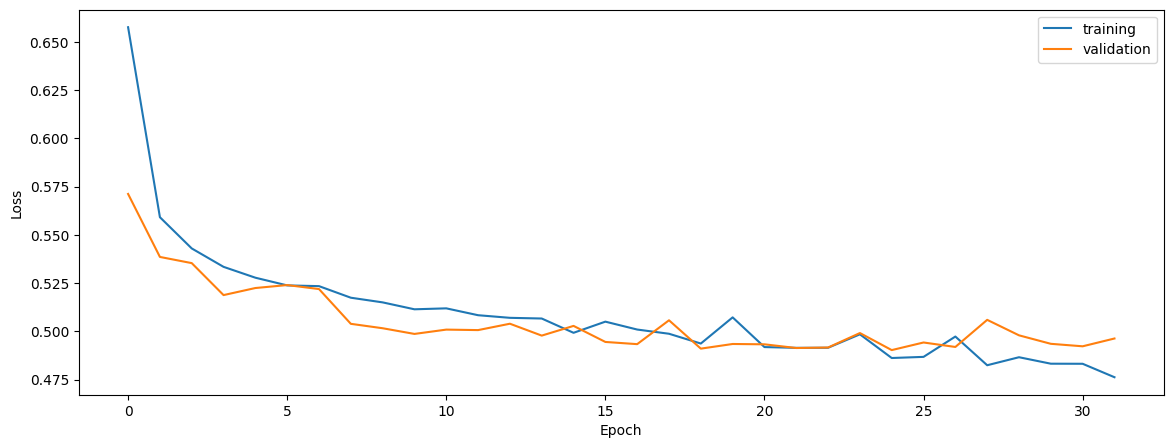

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
import numpy as np

def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1t2','fe':['k5_b25']}]
    props['balance_data'] = False
    props['include_warp'] = True
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print('normalized')
print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

normalized
0.6401849799587782
0.6156467288242731
0.6168493649381118


In [16]:
print('native')
print(getAccuarcy(train_true[1][train_true[2]],train_pred[train_true[2]]))
print(getAccuarcy(val_true[1][val_true[2]],val_pred[val_true[2]]))
print(getAccuarcy(test_true[1][test_true[2]],test_pred[test_true[2]]))

native
0.6353491565500913
0.6203249830737982
0.6104646656997664


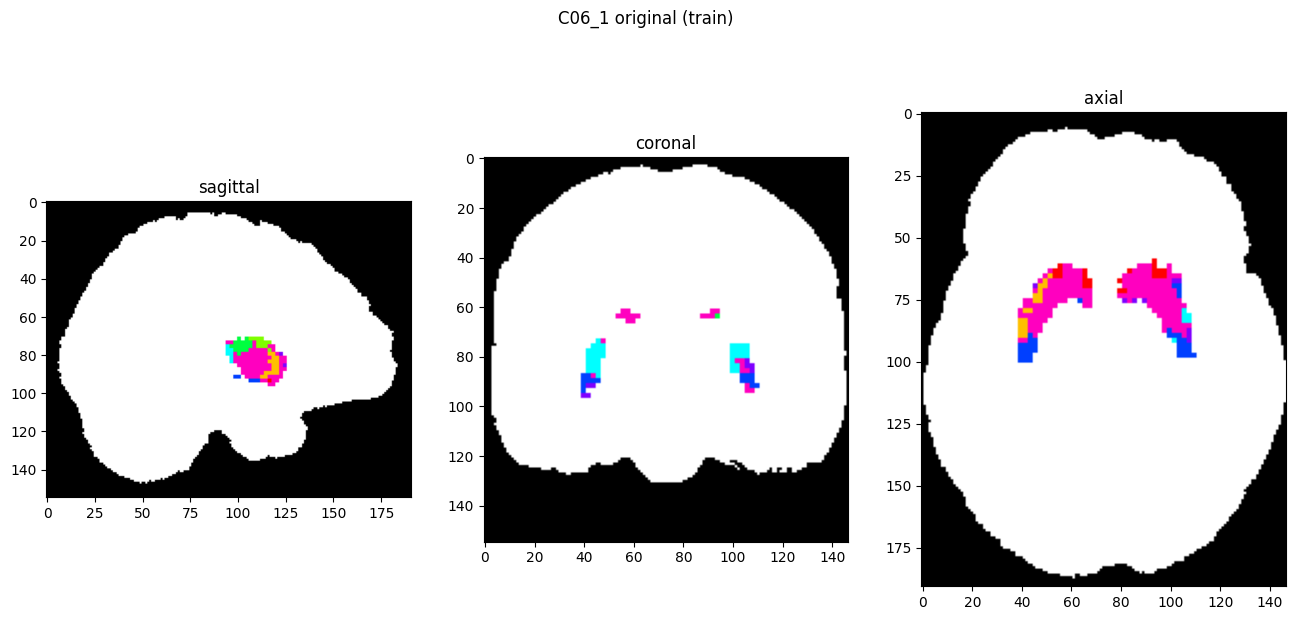

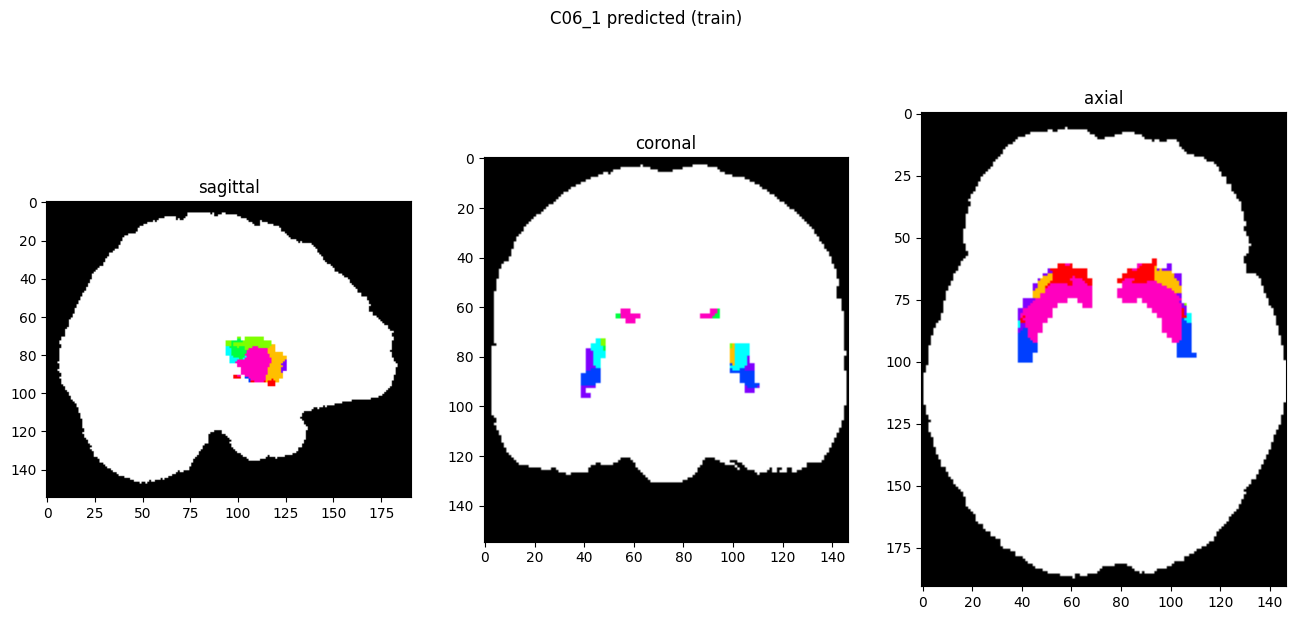

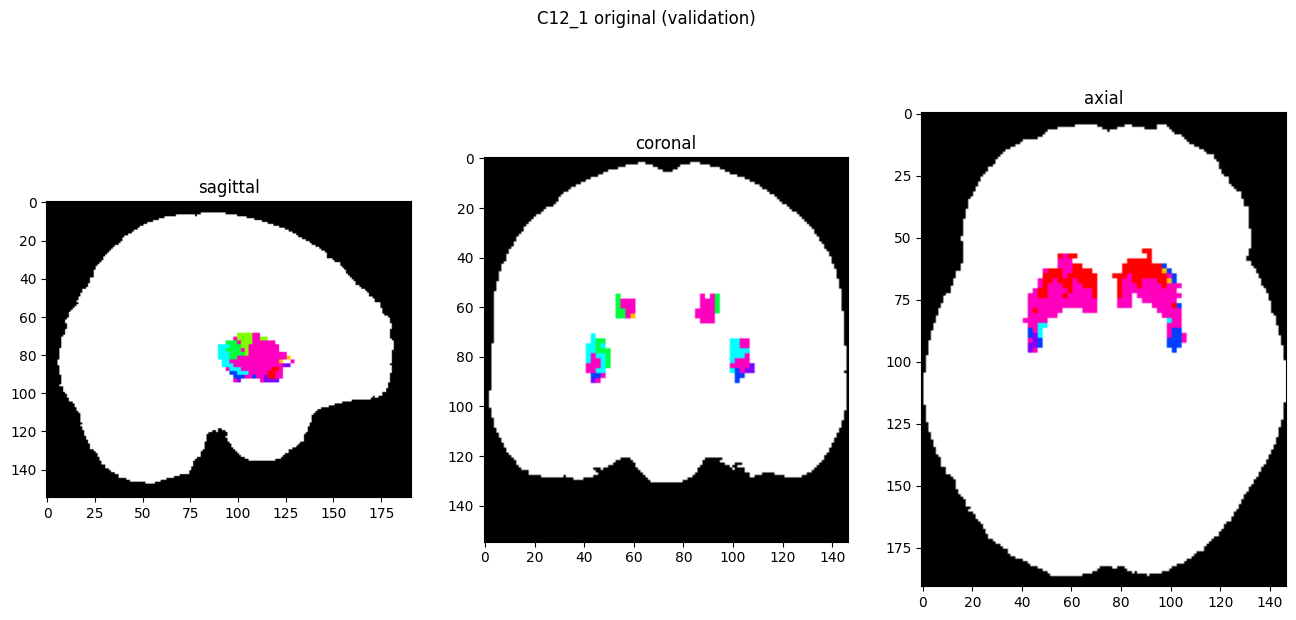

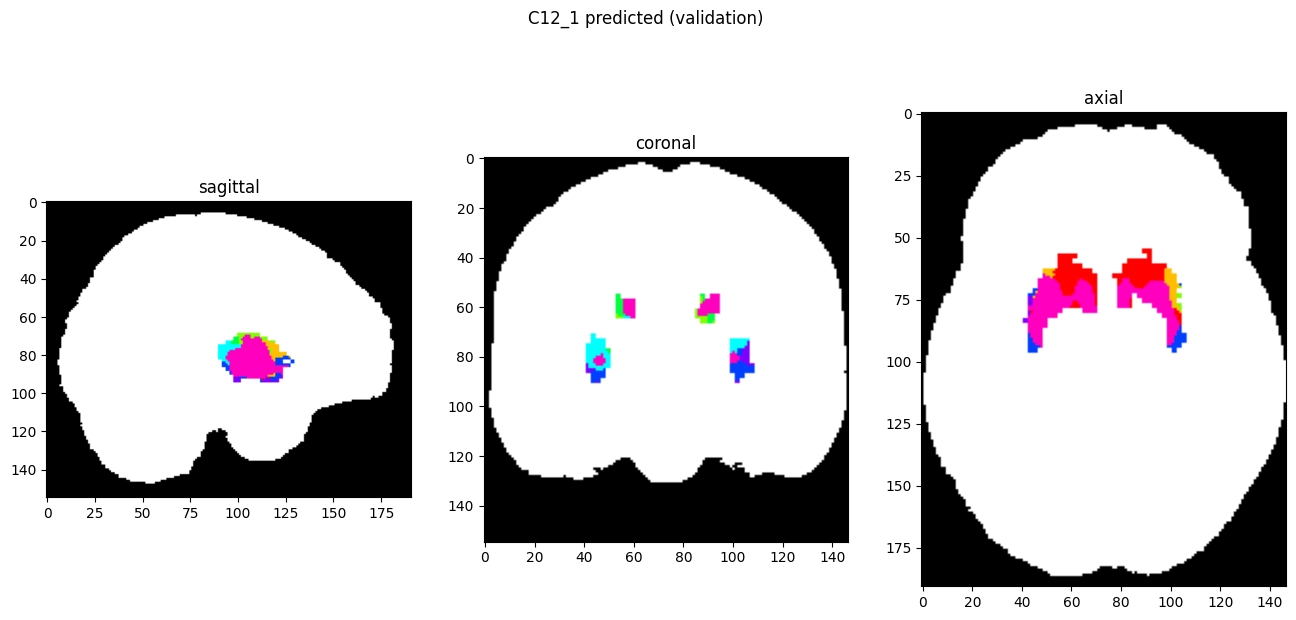

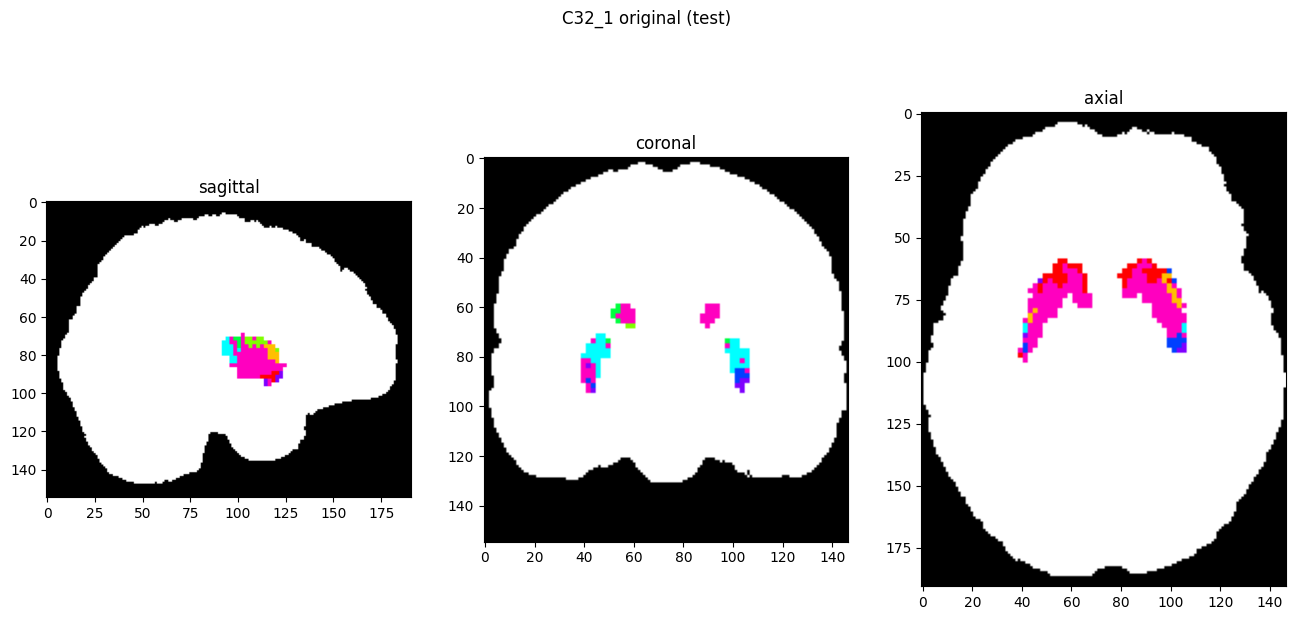

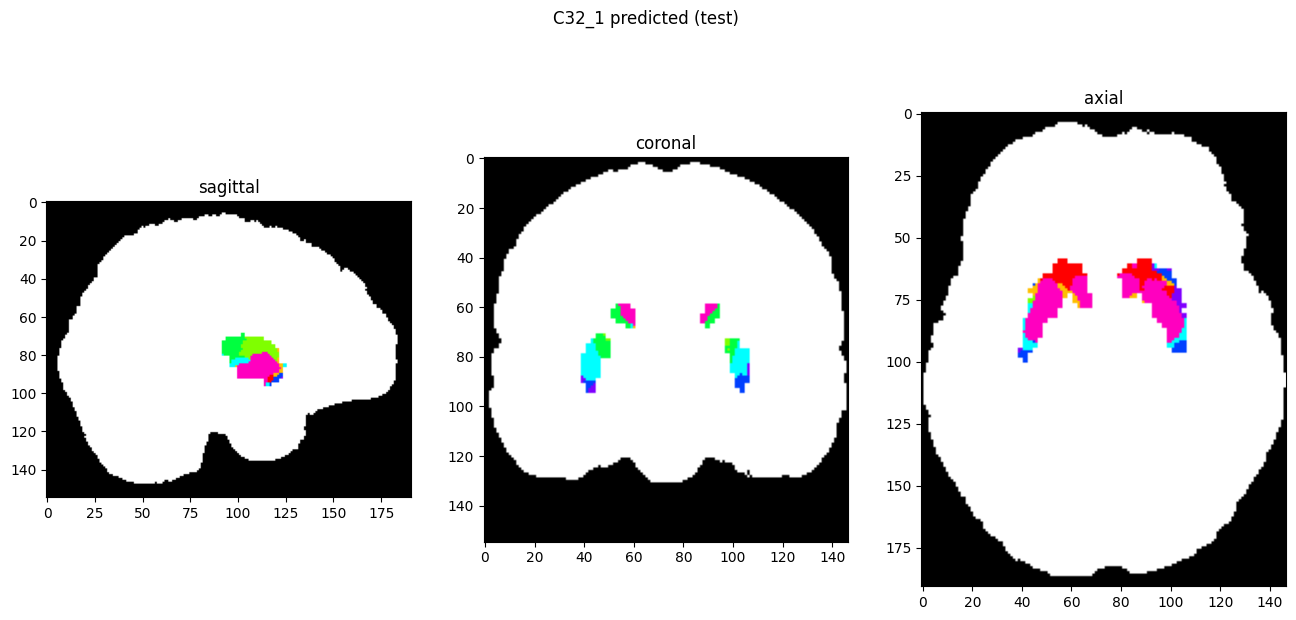

In [17]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)